In [1]:

import time
import casadi as ca
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
import pdb
from random import sample

In [2]:
class Simulator():
    
    def __init__(self,
#                 EV_init     = np.array([0., 12.]),
#                 TV_init     = [np.array([-15., 16.])], 
#                 G_TV_init   = [2.],
                EV_init     = np.array([-40., 0., 10]),
                TV_init     = [np.array([25., 35., -15.]), np.array([36., -40., 13.])], 
                DT          = 0.1,
                T_FINAL     = 500,
                S_FINAL     = 50,
                O_FINAL     = 20,
                O_STOP      = 6.,
                NOISE_STD   =  [0.001, 0.001, 0.2, 0.25]
                ):
        
        self.ev_init=EV_init
        self.N_TV=len(TV_init)
        self.tv_init= [TV_init[k] for k in range(self.N_TV)]
        self.gains=[[.1,0.2], [3,2]]
        self.N_modes=4
        
        self.t=0
        self.dt= DT
        self.T=T_FINAL
        self.s_f=S_FINAL
        self.o_f=O_FINAL
        self.o_s=O_STOP
        self.mode=0
        
        self.A=np.array([[1., 0., self.dt],[0., 1., 0.], [0., 0., 1.]])
        self.B=np.array([0.,0.,self.dt])
        
        self.Atv=np.array([[1., 0., 0.],[0., 1., self.dt], [0., 0., 1.]])
        self.Btv=self.B    
        
        self.ev_traj=np.zeros((3,self.T+1))
        self.ev_u=np.zeros((1,self.T))
        self.ev_traj[:,0]=self.ev_init
        
        self.tv_traj=[np.zeros((3,self.T+1)) for k in range(self.N_TV)]
        
        for k in range(self.N_TV):
            self.tv_traj[k][:,0]=self.tv_init[k]
            
        self.u_prev=0.
        self.noise_std=NOISE_STD
            
        
        
    def TV_gen(self):
            if self.tv_traj[0][1,self.t]< -self.o_f:
#                 self.tv_traj[0]=np.zeros((3,self.T+1))
                self.tv_traj[0][:,self.t]=self.tv_init[0]
                mode_list=[(self.mode+2)%4, self.mode]
#                 self.mode=sample(mode_list,1)[0]
            if self.tv_traj[1][1,self.t]> self.o_f:
#                 self.tv_traj[1]=np.zeros((3,self.T+1))
                self.tv_traj[1][:,self.t]=self.tv_init[1]
                mode_list=[self.mode+(-1)**(self.mode), self.mode]
#                 self.mode=sample(mode_list,1)[0]
                self.mode=self.mode+(-1)**(self.mode)
        
    def done(self):
        return self.t==self.T or self.s_f-self.ev_traj[0,self.t]<=0.1
        
    def get_update_dict(self, N, *args):
        
        if self.t==0:
            x_lin=[np.zeros((3,N+1))]*self.N_modes
            u_tvs=[[np.zeros(N) for j in range(self.N_modes)] for k in range(self.N_TV)]
        else:
            x_lin, u_tvs =self._get_lin_ref(N, *args)
            

        update_dict={'x0': self.ev_traj[0,self.t], 'y0': self.ev_traj[1,self.t], 'v0':self.ev_traj[2,self.t], 'u_prev':self.u_prev,
                     'x_tv0': np.array([self.tv_traj[k][0,self.t] for k in range(self.N_TV)]), 'y_tv0': np.array([self.tv_traj[k][1,self.t] for k in range(self.N_TV)]), 'v_tv0': np.array([self.tv_traj[k][2,self.t] for k in range(self.N_TV)]),
                     'x_lin': x_lin, 'u_tvs': u_tvs}
        if len(args)!=0:
            if len(args)==4:
                [h,M,K,nom_z_tv]=args
                update_dict.update({'ws':[h,M,K]})
            else:
                [h,M,K,lmbd,nu,nom_z_tv]=args
                update_dict.update({'ws':[h,M,K,lmbd,nu]})
            
        return update_dict
        
    
    def run_step(self, u_ev):
#         pdb.set_trace()
        rng=np.random.default_rng(self.t)
#         if self.ev_traj[0,self.t]>=self.s_f-0.35 and self.mode==1:
#             u_ev=-0.1
        self.ev_traj[:,self.t+1]=self.A@self.ev_traj[:,self.t]+self.B*u_ev\
                                    +np.array([rng.normal(0,self.noise_std[0]), 0., rng.normal(0,self.noise_std[1])])
        self.ev_traj[2,self.t+1]=np.max([.0, self.ev_traj[2,self.t+1] ])
        self.ev_u[:,self.t]=u_ev
        self.u_prev=u_ev
        u_tv=[]
        if int(self.mode/2)==0:
            u_tv.append(self.gains[0][0]*( -self.o_f-self.tv_traj[0][1,self.t])+self.gains[0][1]*( 0.-self.tv_traj[0][2,self.t]))
        else:
            u_tv.append(self.gains[1][0]*( self.o_s-self.tv_traj[0][1,self.t])+self.gains[1][1]*( 0.-self.tv_traj[0][2,self.t]))
        if self.mode%2==0:
            u_tv.append(self.gains[0][0]*( self.o_f-self.tv_traj[0][1,self.t])+self.gains[0][1]*( 0.-self.tv_traj[0][2,self.t]))
        else:
            u_tv.append(self.gains[1][0]*( -self.o_s-self.tv_traj[1][1,self.t])+self.gains[1][1]*( 0.-self.tv_traj[1][2,self.t]))

        for k in range(self.N_TV):

            self.tv_traj[k][:,self.t+1]=self.Atv@self.tv_traj[k][:,self.t]+self.Btv*u_tv[k]\
                                            +np.array([0., rng.normal(0,self.noise_std[2]), rng.normal(0,self.noise_std[3])])
            
#         pdb.set_trace()
        self.t+=1
        self.TV_gen()
        
        
    def _get_lin_ref(self, N, *args):#h_opt, M_opt, K_opt, nom_z_tv):
#         R=self._rot2(self.semiaxes_theta)

        
#         pdb.set_trace()
        w=np.diag(np.array(self.noise_std[0:2])**(-1))@(self.ev_traj[0::2,self.t]-self.A[0::2,:]@self.ev_traj[:,self.t-1]-self.B[0::2]*self.u_prev)
        
        
        x0=[self.ev_traj[:,self.t] for j in range(self.N_modes)]
        o0=[[self.tv_traj[k][:,self.t] for k in range(self.N_TV)] for j in range(self.N_modes)]
        elim_stop=False
        if o0[0][0][1]>0:
            elim_stop=True
        x_lin=[np.zeros((3,N+1)) for j in range(self.N_modes)]
        u_tvs=[[np.zeros(N) for j in range(self.N_modes)] for k in range(self.N_TV)]
        for j in range(self.N_modes):
            x=x0[j]
            o=o0[j]
            x_lin[j][:,0]=x   
            w_seq=np.zeros(2*N)
            w_seq[:2]=w
            
            if len(args)==0:
                h_opt=[np.zeros((N,1))]*self.N_modes
                M_opt=[np.zeros((N,2*N))]*self.N_modes
                K_opt=[[np.zeros((N,2*N))]*self.N_TV]*self.N_modes
            else:        
                if len(args)==4:
                    [h_opt,M_opt,K_opt,nom_z_tv]=args
                else:
                    [h_opt,M_opt,K_opt,lmbd,nu,nom_z_tv]=args

                for i in range(1,N):
    
                    u=h_opt[j][i]+M_opt[j][i,:]@w_seq+np.sum([K_opt[j][l][i,2*i:2*(i+1)]@(o[l][1:]-nom_z_tv[j][l][3*i+1:3*(i+1)]) for l in range(self.N_TV)])
                    if i==1:
                        self.u_prev=u
                    if int(j/2)==0 or elim_stop:
                        u_tvs[0][j][i-1]=self.gains[0][0]*( -self.o_f-o[0][1])+self.gains[0][1]*( -0-o[0][2])
                    else:
                        u_tvs[0][j][i-1]=self.gains[1][0]*( self.o_s-o[0][1])+self.gains[1][1]*( -0-o[0][2])
                    if j%2==0:
                        u_tvs[1][j][i-1]=self.gains[0][0]*( self.o_f-o[1][1])+self.gains[0][1]*( -0-o[1][2])
                    else:
                        u_tvs[1][j][i-1]=self.gains[1][0]*( -self.o_s-o[1][1])+self.gains[1][1]*( 0-o[1][2])
                    
                    o=[self.Atv@o[k]+self.Btv*u_tvs[k][j][i-1] for k in range(self.N_TV)]
                    if i==N-1:
                        if int(j/2)==0:
                            u_tvs[0][j][i]=self.gains[0][0]*( -self.o_f-o[0][1])+self.gains[0][1]*( 0-o[0][2])
                        else:
                            u_tvs[0][j][i]=self.gains[1][0]*( self.o_s-o[0][1])+self.gains[1][1]*( 0-o[0][2])
                        if j%2==0:
                            u_tvs[1][j][i]=self.gains[0][0]*( self.o_f-o[1][1])+self.gains[0][1]*( 0-o[1][2])
                        else:
                            u_tvs[1][j][i]=self.gains[1][0]*( -self.o_s-o[1][1])+self.gains[1][1]*( 0-o[1][2])
                        
                    x=self.A@x+self.B*u
                    x_lin[j][:,i]=x
                    x_lin[j][:,i+1]=x
#                 print(x_lin[j])  
#                 print(nom_z_tv[j])
        return x_lin, u_tvs
        
    
        
   

In [3]:
class SMPC_MMPreds():
    
#     def __init__(self,
#                 N            =  20,
#                 DT           = 0.1,
#                 V_MIN        = 0.0,
#                 V_MAX        = 15.0, 
#                 A_MIN        = -7.0,
#                 A_MAX        =  3.0, 
#                 N_modes_MAX  =  1,
#                 N_TV         =  1,
#                 T_BAR_MAX    =  7,
#                 D_NOM        =  7,
#                 S_FINAL      =  60, 
#                 TIGHTENING   =  1.6,
#                 NOISE_STD    =  [0.01, 0.01, 0.02, .05, .5], # process noise standard deviations in order [w_x, w_y, w_theta, w_v, w_TV] 
#                 Q = [100., 100.], # weights on x, y, and v.
#                 R = 100.,       # weights on inputs 
#                 Estimate=False 
#                 ):
    def __init__(self,
                N            =  12,
                DT           = 0.1,
                V_MIN        = -0.5,
                V_MAX        = 12.0, 
                A_MIN        = -8.0,
                A_MAX        =  5.0, 
                N_modes_MAX  =  4,
                N_TV         =  2,
                T_BAR_MAX    =  8,
                D_NOM        =  7.2,
                S_FINAL      =  100,
                O_FINAL      =  20, 
                O_STOP       =  6.,
                TIGHTENING   =  1.9,
                NOISE_STD    =  [0.001, 0.001, 0.002, 0.002], # process noise standard deviations in order [w_x, w_y, w_theta, w_v, w_TV] 
                Q = 100., # weights on x, y, and v.
                R = 100.,
#                 Q = [100., 20.], # weights on x, y, and v.
#                 R = 200.,       # weights on inputs 
                OL_FLAG     = False 
                ):
        self.N=N
        self.DT=DT
        self.V_MIN=V_MIN
        self.V_MAX=V_MAX
        self.A_MAX=A_MAX
        self.A_MIN=A_MIN
        self.N_modes=N_modes_MAX
        self.N_TV=N_TV
        self.t_bar_max=T_BAR_MAX
#         self.t_bar_max=self.N-1
        self.d_nom=D_NOM
        self.s_f=S_FINAL
        self.o_f=O_FINAL
        self.o_s=O_STOP
        self.tight=TIGHTENING
        self.noise_std=NOISE_STD
        self.Q = ca.diag(Q)
        self.R = ca.diag(R)
        self.OL=OL_FLAG
        self.A=ca.DM([[1., 0., self.DT],[0., 1., 0.], [0., 0., 1.]])
        self.B=ca.DM([0.,0.,self.DT])
        
        self.Atv=ca.DM([[1., 0., 0.],[0., 1., self.DT], [0., 0., 1.]])
        self.Btv=self.B
        
        self.gains=[ca.DM([[0,.1,0.2]]), ca.DM([[0,3,2]])]
  
        
        self.nom_z_tv=[]
        
        self.opti=[]

        self.u_backup=[]
        self.z_curr=[]
        self.u_prev=[]
        self.mode_list=[]

        self.z_lin=[]
        self.T_tv=[]
        self.c_tv=[]
        self.E_tv=[]
        self.z_tv_curr=[]
#         self.term_flag=[]
        self.policy=[]
        
#         p_opts = {'expand': True}
#         s_opts = {'max_cpu_time': 0.15, 'print_level': 0} 
        p_opts_grb = {'OutputFlag': 0, 'FeasibilityTol' : 1e-4, 'PSDTol' : 1e-3}
        s_opts_grb = {'error_on_fail':0}
        
        for i in range(self.t_bar_max):
#         for i in range(3,4):    
            self.opti.append(ca.Opti('conic'))
            self.opti[i].solver("gurobi", s_opts_grb, p_opts_grb)
#             self.opti[i].solver("superscs", {}, p_opts)
            
            self.z_curr.append(self.opti[i].parameter(3))
            self.u_prev.append(self.opti[i].parameter(1))
#             self.term_flag.append(self.opti[i].parameter(1))
            
            N_TV=self.N_TV
            t_bar=i
            
            
            self.z_lin.append([self.opti[i].parameter(3,self.N+1) for j in range(self.N_modes)])
            self.T_tv.append([[self.opti[i].parameter(3*(self.N+1), 3) for j in range(self.N_modes)] for k in range(N_TV)])
            self.c_tv.append([[self.opti[i].parameter(3*(self.N+1), 1) for j in range(self.N_modes)] for k in range(N_TV)])
            self.E_tv.append([[self.opti[i].parameter(3*(self.N+1),self.N*2) for j in range(self.N_modes)] for k in range(N_TV)])
            
            self.z_tv_curr.append(self.opti[i].parameter(3*N_TV))
            
            self.policy.append(self._return_policy_class(i, N_TV, t_bar))
            self._add_constraints_and_cost(i, N_TV, t_bar)
            
            self._update_ev_initial_condition(i, 0., 10., 0., 0. )
            self._update_tv_initial_condition(i, N_TV*[25.], N_TV*[10.], N_TV*[0.], N_TV*[self.N_modes*[np.zeros(self.N)]] )
            self._update_ev_preds(i, self.N_modes*[np.zeros((3,self.N+1))])
            
#             if i==10:
#                 sol=self.solve(i)

    
    def _return_policy_class(self, i, N_TV, t_bar):
        
        if t_bar == 0 or t_bar==self.N-1 or self.OL:
            h=[[self.opti[i].variable(1)] for t in range(self.N)]
            if not self.OL:
                M=[[[self.opti[i].variable(1, 2)] for j in range(t)] for t in range(self.N)]
                K=[[[self.opti[i].variable(1,2) for k in range(N_TV)]] for t in range(self.N)]
            else:
                M=[[[ca.DM(np.zeros((1, 2)))] for j in range(t)] for t in range(self.N)]
                K=[[[ca.DM(np.zeros((1, 2))) for k in range(N_TV)]] for t in range(self.N)]
            
            M_stack=[ca.vertcat(*[ca.horzcat(*[M[t][j][0] for j in range(t)], ca.MX(1,2*(self.N-t))) for t in range(self.N)])]
            h_stack=[ca.vertcat(*[h[t][0] for t in range(self.N)])]
            K_stack=[[ca.diagcat(*[K[t][0][k] for t in range(self.N)]) for k in range(N_TV)]]
#             pdb.set_trace()
        else:
            h=[[self.opti[i].variable(1) for n in range(1+(-1+self.N_modes)*int(t>=t_bar))] for t in range(self.N)]
            if not self.OL:
                M=[[[ca.DM(np.zeros((1, 2))) for n in range(1+(-1+self.N_modes)*int(t>=t_bar))] for j in range(t)] for t in range(self.N)]
#                 M=[[[self.opti[i].variable(1, 2) for n in range(1+(-1+self.N_modes)*int(t>=t_bar))] for j in range(t)] for t in range(self.N)]
                K=[[[self.opti[i].variable(1,2) for k in range(N_TV)] for n in range(1+(-1+self.N_modes)*int(t>=t_bar))] for t in range(self.N)]
            else:
                M=[[[ca.DM(np.zeros((1, 2))) for n in range(1+(-1+self.N_modes)*int(t>=t_bar))] for j in range(t)] for t in range(self.N)]
                K=[[[ca.DM(np.zeros((1, 2))) for k in range(N_TV)] for n in range(1+(-1+self.N_modes)*int(t>=t_bar))] for t in range(self.N)]
            
            M_stack=[ca.vertcat(*[ca.horzcat(*[M[t][j][m*int(t>=t_bar)] for j in range(t)], ca.DM(1,2*(self.N-t))) for t in range(self.N)]) for m in range(self.N_modes)]
            h_stack=[ca.vertcat(*[h[t][m*int(t>=t_bar)] for t in range(self.N)]) for m in range(self.N_modes)]
            K_stack=[[ca.diagcat(*[K[t][m*int(t>=t_bar)][k] for t in range(self.N)]) for k in range(N_TV)] for m in range(self.N_modes)]
        
        return h_stack,M_stack,K_stack
        
    def _set_ATV_TV_dynamics(self, i, y_tv0, u_tvs, N_TV):
        
        
        E=ca.DM([[0., 0.],[self.noise_std[2], 0.],[0., self.noise_std[3]]])
                
        T_tv=[[ca.DM(3*(self.N+1), 3) for j in range(self.N_modes)] for k in range(N_TV)]
        c_tv=[[ca.DM(3*(self.N+1), 1) for j in range(self.N_modes)] for k in range(N_TV)]
        E_tv=[[ca.DM(3*(self.N+1),self.N*2) for j in range(self.N_modes)] for k in range(N_TV)]
        
        elim_stop=False
        if y_tv0[0]<0:
            elim_stop=True
        
        for k in range(N_TV):
            for j in range(self.N_modes):
                for t in range(self.N+1):
                    if t==0:
                        T_tv[k][j][:3,:]=ca.DM.eye(3)
                    else:
                        if k==0:
                            if int(j/2)==0 or elim_stop:
#                                 if not self.OL:
#                                     T_tv[k][j][t*3:(t+1)*3,:]=(self.Atv-self.Btv@self.gains[0])@T_tv[k][j][(t-1)*3:t*3,:]
#                                     c_tv[k][j][t*3:(t+1)*3,:]=self.Btv@self.gains[0]@ca.DM([0.,-self.o_f, 0.])+(self.Atv-self.Btv@self.gains[0])@c_tv[k][j][(t-1)*3:t*3,:]
#                                     E_tv[k][j][t*3:(t+1)*3,:]=(self.Atv-self.Btv@self.gains[0])@E_tv[k][j][(t-1)*3:t*3,:]
#                                 else:
                                T_tv[k][j][t*3:(t+1)*3,:]=self.Atv@T_tv[k][0][(t-1)*3:t*3,:]
                                c_tv[k][j][t*3:(t+1)*3,:]=self.Btv@u_tvs[k][0][t-1]+self.Atv@c_tv[k][j][(t-1)*3:t*3,:]
                                E_tv[k][j][t*3:(t+1)*3,:]=self.Atv@E_tv[k][0][(t-1)*3:t*3,:]    
                                
                                E_tv[k][j][t*3:(t+1)*3,(t-1)*2:t*2]=E
                            else:
#                                 if not self.OL:
#                                     T_tv[k][j][t*3:(t+1)*3,:]=(self.Atv-self.Btv@self.gains[1])@T_tv[k][j][(t-1)*3:t*3,:]
#                                     c_tv[k][j][t*3:(t+1)*3,:]=self.Btv@self.gains[1]@ca.DM([0.,self.o_s, 0.])+(self.Atv-self.Btv@self.gains[1])@c_tv[k][j][(t-1)*3:t*3,:]
#                                     E_tv[k][j][t*3:(t+1)*3,:]=(self.Atv-self.Btv@self.gains[1])@E_tv[k][j][(t-1)*3:t*3,:]
#                                 else:
                                T_tv[k][j][t*3:(t+1)*3,:]=self.Atv@T_tv[k][j][(t-1)*3:t*3,:]
                                c_tv[k][j][t*3:(t+1)*3,:]=self.Btv@u_tvs[k][j][t-1]+self.Atv@c_tv[k][j][(t-1)*3:t*3,:]
                                E_tv[k][j][t*3:(t+1)*3,:]=self.Atv@E_tv[k][j][(t-1)*3:t*3,:]   
                                E_tv[k][j][t*3:(t+1)*3,(t-1)*2:t*2]=E
                        else:
                            if j%2==0:
#                                 if not self.OL:
#                                     T_tv[k][j][t*3:(t+1)*3,:]=(self.Atv-self.Btv@self.gains[0])@T_tv[k][j][(t-1)*3:t*3,:]
#                                     c_tv[k][j][t*3:(t+1)*3,:]=self.Btv@self.gains[0]@ca.DM([0.,self.o_f, 0.])+(self.Atv-self.Btv@self.gains[0])@c_tv[k][j][(t-1)*3:t*3,:]
#                                     E_tv[k][j][t*3:(t+1)*3,:]=(self.Atv-self.Btv@self.gains[0])@E_tv[k][j][(t-1)*3:t*3,:]
#                                 else:
                                T_tv[k][j][t*3:(t+1)*3,:]=self.Atv@T_tv[k][j][(t-1)*3:t*3,:]
                                c_tv[k][j][t*3:(t+1)*3,:]=self.Btv@u_tvs[k][j][t-1]+self.Atv@c_tv[k][j][(t-1)*3:t*3,:]
                                E_tv[k][j][t*3:(t+1)*3,:]=self.Atv@E_tv[k][j][(t-1)*3:t*3,:]   
                                E_tv[k][j][t*3:(t+1)*3,(t-1)*2:t*2]=E
                            else:
#                                 if not self.OL:
#                                     T_tv[k][j][t*3:(t+1)*3,:]=(self.Atv-self.Btv@self.gains[1])@T_tv[k][j][(t-1)*3:t*3,:]
#                                     c_tv[k][j][t*3:(t+1)*3,:]=self.Btv@self.gains[1]@ca.DM([0.,-self.o_s, 0.])+(self.Atv-self.Btv@self.gains[1])@c_tv[k][j][(t-1)*3:t*3,:]
#                                     E_tv[k][j][t*3:(t+1)*3,:]=(self.Atv-self.Btv@self.gains[1])@E_tv[k][j][(t-1)*3:t*3,:]
#                                 else:
                                T_tv[k][j][t*3:(t+1)*3,:]=self.Atv@T_tv[k][j][(t-1)*3:t*3,:]
                                c_tv[k][j][t*3:(t+1)*3,:]=self.Btv@u_tvs[k][j][t-1]+self.Atv@c_tv[k][j][(t-1)*3:t*3,:]
                                E_tv[k][j][t*3:(t+1)*3,:]=self.Atv@E_tv[k][j][(t-1)*3:t*3,:]   
                                E_tv[k][j][t*3:(t+1)*3,(t-1)*2:t*2]=E
#                 pdb.set_trace()
                self.opti[i].set_value(self.T_tv[i][k][j], T_tv[k][j])
                self.opti[i].set_value(self.c_tv[i][k][j], c_tv[k][j])
                self.opti[i].set_value(self.E_tv[i][k][j], E_tv[k][j])
    


        
    
    def _get_LTV_EV_dynamics(self, i, N_TV):
        

        E=ca.DM([[self.noise_std[0], 0.], [0., 0.], [0., self.noise_std[1]]])
                
        A_pred=ca.DM(3*(self.N+1), 3)
        B_pred=ca.DM(3*(self.N+1),self.N)
        E_pred=ca.DM(3*(self.N+1),self.N*2)
        
        A_pred[:3,:]=ca.DM.eye(3)
        
        for t in range(1,self.N+1):
                A_pred[t*3:(t+1)*3,:]=self.A@A_pred[(t-1)*3:t*3,:]
                
                B_pred[t*3:(t+1)*3,:]=self.A@B_pred[(t-1)*3:t*3,:]
                B_pred[t*3:(t+1)*3,t-1]=self.B
                
                E_pred[t*3:(t+1)*3,:]=self.A@E_pred[(t-1)*3:t*3,:]
                E_pred[t*3:(t+1)*3,(t-1)*2:t*2]=E
                
        
        return A_pred,B_pred,E_pred
        
    def _add_constraints_and_cost(self, i, N_TV, t_bar):
        

        [A,B,E]=self._get_LTV_EV_dynamics(i, N_TV)
        T_tv=self.T_tv[i]
        c_tv=self.c_tv[i]
        E_tv=self.E_tv[i]
        [h,M,K]=self.policy[i]

        nom_z_tv_i=[[T_tv[k][j]@self.z_tv_curr[i][3*k:3*(k+1)]+c_tv[k][j] for k in range(N_TV)] for j in range(self.N_modes)]
        self.nom_z_tv.append(nom_z_tv_i)
        
        sel_W=ca.kron(ca.DM.eye(self.N), ca.DM([[0.,1.,0],[0., 0., 1.]]))
        
        cost = 0
   
        for j in range(self.N_modes):

            if len(h)>1:
                uh=h[j]
                uM=M[j]
                uK=K[j]
            else:
                uh=h[0]
                uM=M[0]
                uK=K[0]
                
            self.opti[i].subject_to(self.opti[i].bounded(self.A_MIN, uh, self.A_MAX))
            
            ev_rv=ca.horzcat(B[3:,:]@uM+E[3:,:],*[B[3:,:]@uK[l]@sel_W@E_tv[l][j][3:,:] for l in range(N_TV)])
            for t in range(1,self.N+1):

                self.opti[i].subject_to(self.opti[i].bounded(self.V_MIN, A[t*3+2,:]@self.z_curr[i]+B[t*3+2,:]@uh, self.V_MAX))

                for k in range(N_TV):
#                         pdb.set_trace()
#                         oa_ref=nom_z_tv_i[j][k][3*t:3*t+2]+self.d_nom/ca.norm_2(self.z_lin[i][j][:2,t]-nom_z_tv_i[j][k][3*t:3*t+2])*(self.z_lin[i][j][:2,t]-nom_z_tv_i[j][k][3*t:3*t+2])
                    oa_ref=nom_z_tv_i[j][k][3*t:3*t+2]+self.d_nom/ca.norm_2(self.z_curr[i][:2]-nom_z_tv_i[j][k][3*t:3*t+2])*(self.z_curr[i][:2]-nom_z_tv_i[j][k][3*t:3*t+2])

                    soc_constr=ca.soc(self.tight*(2*(oa_ref-nom_z_tv_i[j][k][3*t:3*t+2]).T@ca.DM([[1, 0, 0], [0, 1, 0]])@(ca.horzcat(B[t*3:(t+1)*3,:]@uM+E[t*3:(t+1)*3,:],*[B[t*3:(t+1)*3,:]@uK[l]@sel_W@E_tv[l][j][:3*self.N,:]-int(l==k)*E_tv[k][j][t*3:(t+1)*3,:] for l in range(N_TV)]))),
                                          -1.*self.d_nom-(oa_ref-nom_z_tv_i[j][k][3*t:3*t+2]).T@(oa_ref-nom_z_tv_i[j][k][3*t:3*t+2])\
                                          +2*(oa_ref-nom_z_tv_i[j][k][3*t:3*t+2]).T@ca.DM([[1, 0, 0], [0, 1, 0]])@(A[t*3:(t+1)*3,:]@self.z_curr[i]+B[t*3:(t+1)*3,:]@uh-T_tv[k][j][t*3:(t+1)*3,:]@self.z_tv_curr[i][3*k:3*(k+1)]-c_tv[k][j][t*3:(t+1)*3,:]))

                    self.opti[i].subject_to(soc_constr>0)

#                     self.opti[i].subject_to(ca.norm_2(self.tight*(2*(oa_ref-nom_z_tv_i[j][k][3*t:3*t+2]).T@ca.DM([[1, 0, 0], [0, 1, 0]])@(ca.horzcat(B[t*3:(t+1)*3,:]@uM+E[t*3:(t+1)*3,:],*[B[t*3:(t+1)*3,:]@uK[l]@sel_W@E_tv[l][j][3:,:]-int(l==k)*E_tv[k][j][t*3:(t+1)*3,:] for l in range(N_TV)]))))<=\
#                                            -1.*self.d_nom-(oa_ref-nom_z_tv_i[j][k][3*t:3*t+2]).T@(oa_ref-nom_z_tv_i[j][k][3*t:3*t+2])\
#                                             +2*(oa_ref-nom_z_tv_i[j][k][3*t:3*t+2]).T@ca.DM([[1, 0, 0], [0, 1, 0]])@(A[t*3:(t+1)*3,:]@self.z_curr[i]+B[t*3:(t+1)*3,:]@uh-T_tv[k][j][t*3:(t+1)*3,:]@self.z_tv_curr[i][3*k:3*(k+1)]-c_tv[k][j][t*3:(t+1)*3,:]))


#                 cost+=(A[t*3:(t+1)*3:2,:]@self.z_curr[i]+B[t*3:(t+1)*3:2,:]@uh-ca.DM([self.s_f, 0.])).T@self.Q@(A[t*3:(t+1)*3:2,:]@self.z_curr[i]+B[t*3:(t+1)*3:2,:]@uh-ca.DM([self.s_f, 0.]))
#                     cost+=-self.Q[0,0]*(A[t*3,:]@self.z_curr[i]+B[t*3,:]@h[j])

#                 cost+=uh[t-1]@self.R@uh[t-1]
#                 soc_term=ca.soc(ca.norm_2(ca.vertcat(0.5+1*self.A_MIN*20-1*self.A_MIN*(A[3*self.N,:]@self.z_curr[i]+B[3*self.N,:]@h[j]),A[3*self.N+2,:]@self.z_curr[i]+B[3*self.N+2,:]@h[j])),
#                                 0.5-1*self.A_MIN*(20-A[3*self.N,:]@self.z_curr[i]+B[3*self.N,:]@h[j]))
#                 self.opti[i].subject_to(soc_term>0)
#                 if self.term_flag[i]>0.:
#                     self.opti[i].subject_to(ca.norm_2(ca.vertcat(0.5+1*self.A_MIN*20-1*self.A_MIN*(A[3*self.N,:]@self.z_curr[i]+B[3*self.N,:]@h[j]),A[3*self.N+2,:]@self.z_curr[i]+B[3*self.N+2,:]@h[j]))<=0.5-1*self.A_MIN*(20-A[3*self.N,:]@self.z_curr[i]-B[3*self.N,:]@h[j]))

            nom_z=A@self.z_curr[i]+B@uh
            nom_z_diff=ca.diff(nom_z.reshape((3,-1)),1,1).reshape((-1,1))
#             cost+=10*(nom_z_diff.T@nom_z_diff+100.*ca.trace(ev_rv@ev_rv.T))
            cost+=-self.Q*ca.sum1(ca.diff(nom_z.reshape((3,-1)),1,1)[0,:].T)
            cost+=self.R*ca.diff(ca.vertcat(self.u_prev[i],uh),1,0).T@ca.diff(ca.vertcat(self.u_prev[i],uh),1,0)
            
        
        self.opti[i].minimize( cost )   


        

    def solve(self, i):
        st = time.time()

        try:
#             pdb.set_trace()
            sol = self.opti[i].solve()
            # Optimal solution.
            
            u_control  = sol.value(self.policy[i][0][0][0])
            if not self.OL:
                h_opt      = [sol.value(self.policy[i][0][j]) for j in range(self.N_modes)]
                M_opt      = [sol.value(self.policy[i][1][j]) for j in range(self.N_modes)] 
                K_opt      = [[sol.value(self.policy[i][2][j][k]) for k in range(self.N_TV)] for j in range(self.N_modes)] 
            else:
                h_opt      = [sol.value(self.policy[i][0][0]) for j in range(self.N_modes)]
                M_opt      = [sol.value(self.policy[i][1][0]) for j in range(self.N_modes)] 
                K_opt      = [[sol.value(self.policy[i][2][0][k]) for k in range(len(self.policy[i][2][0]))] for j in range(self.N_modes)] 
            
            nom_z_tv   = [[sol.value(self.nom_z_tv[i][j][k]) for k in range(len(self.policy[i][2][0]))] for j in range(self.N_modes)]
            
            is_opt     = True
        except:
            # Suboptimal solution (e.g. timed out).
            u_control  = self.u_backup

            is_opt = False

        solve_time = time.time() - st
        
        sol_dict = {}
        sol_dict['u_control']  = u_control  # control input to apply based on solution
        sol_dict['optimal']    = is_opt      # whether the solution is optimal or not
        if is_opt:
                sol_dict['h_opt']=h_opt
                sol_dict['M_opt']=M_opt
                sol_dict['K_opt']=K_opt
                sol_dict['nom_z_tv']=nom_z_tv
                
        sol_dict['solve_time'] = solve_time  # how long the solver took in seconds


        return sol_dict

    def update(self, i, update_dict):
        self._update_ev_initial_condition(i, *[update_dict[key] for key in ['x0','y0', 'v0', 'u_prev']] )
        self._update_tv_initial_condition(i, *[update_dict[key] for key in ['x_tv0', 'y_tv0', 'v_tv0', 'u_tvs']] )
        self._update_ev_preds(i, update_dict['x_lin'])
    


    def _update_ev_initial_condition(self, i, x0, y0,  v0, u_prev):
        self.opti[i].set_value(self.z_curr[i], ca.DM([x0, y0, v0]))
        self.opti[i].set_value(self.u_prev[i], u_prev)
#         if self.OL:
#             self.u_backup=u_prev
#         else:
        self.u_backup=self.A_MIN
#         self.u_backup=u_prev
                  
    def _update_tv_initial_condition(self, i, x_tv0, y_tv0, v_tv0, u_tvs):
        

        for k in range(self.N_TV):
            self.opti[i].set_value(self.z_tv_curr[i][3*k:3*(k+1)], ca.DM([x_tv0[k], y_tv0[k], v_tv0[k]]))
#             if y_tv0[0]>0.:
#                 self.opti[i].set_value(self.term_flag[i], 1.)
#             else:
#                 self.opti[i].set_value(self.term_flag[i], 0.)
        self._set_ATV_TV_dynamics(i, y_tv0, u_tvs, self.N_TV)


    
    def _update_ev_preds(self, i, x_lin):
        
        for j in range(self.N_modes):
   
            self.opti[i].set_value(self.z_lin[i][j],x_lin[j])
                    
        

In [4]:
class SMPC_MMPreds_OBCA():
    
#     def __init__(self,
#                 N            =  20,
#                 DT           = 0.1,
#                 V_MIN        = 0.0,
#                 V_MAX        = 15.0, 
#                 A_MIN        = -7.0,
#                 A_MAX        =  3.0, 
#                 N_modes_MAX  =  1,
#                 N_TV         =  1,
#                 T_BAR_MAX    =  7,
#                 D_NOM        =  7,
#                 S_FINAL      =  60, 
#                 TIGHTENING   =  1.6,
#                 NOISE_STD    =  [0.01, 0.01, 0.02, .05, .5], # process noise standard deviations in order [w_x, w_y, w_theta, w_v, w_TV] 
#                 Q = [100., 100.], # weights on x, y, and v.
#                 R = 100.,       # weights on inputs 
#                 Estimate=False 
#                 ):
    def __init__(self,
                N            =  12,
                DT           = 0.1,
                V_MIN        = -0.5,
                V_MAX        = 12.0, 
                A_MIN        = -8.0,
                A_MAX        =  5.0, 
                N_modes_MAX  =  4,
                N_TV         =  2,
                T_BAR_MAX    =  8,
                D_NOM        =  1.5,
                S_FINAL      =  100,
                O_FINAL      =  20, 
                O_STOP       =  6.,
                TIGHTENING   =  1.9,
                NOISE_STD    =  [0.001, 0.001, 0.002, 0.002], # process noise standard deviations in order [w_x, w_y, w_theta, w_v, w_TV] 
                Q = 100., # weights on x, y, and v.
                R = 100.,       # weights on inputs 
                OL_FLAG     = False 
                ):
        self.N=N
        self.DT=DT
        self.V_MIN=V_MIN
        self.V_MAX=V_MAX
        self.A_MAX=A_MAX
        self.A_MIN=A_MIN
        self.N_modes=N_modes_MAX
        self.N_TV=N_TV
        self.t_bar_max=T_BAR_MAX
#         self.t_bar_max=self.N-1
        self.d_nom=D_NOM
        self.s_f=S_FINAL
        self.o_f=O_FINAL
        self.o_s=O_STOP
        self.tight=TIGHTENING
        self.noise_std=NOISE_STD
        self.Q = ca.diag(Q)
        self.R = ca.diag(R)
        self.OL=OL_FLAG
        self.A=ca.DM([[1., 0., self.DT],[0., 1., 0.], [0., 0., 1.]])
        self.B=ca.DM([0.,0.,self.DT])
        
        self.Rtv=ca.DM([[0.,1.],[-1.,0.]])
        self.G=ca.DM([[1., 0.],[-1.,0. ], [0, 1.],[0.,-1. ]])
        self.g=ca.DM([[3.2],[3.2], [1.8],[1.8]])
        
        self.Atv=ca.DM([[1., 0., 0.],[0., 1., self.DT], [0., 0., 1.]])
        self.Btv=self.B
        
        self.gains=[ca.DM([[0,.1,0.2]]), ca.DM([[0,3,2]])]
  
        
        self.nom_z_tv=[]
        self.oa_constr=[]
        self.oa_lconstr=[]
        
        self.opti=[]

        self.u_backup=[]
        self.z_curr=[]
        self.u_prev=[]
        self.h_prev=[]
        self.M_prev=[]
        self.K_prev=[]
        self.lmbd_prev=[]
        self.nu_prev=[]
        self.mode_list=[]

        self.lmbd_dual_var=[]
        self.nu_dual_var=[]

        self.z_lin=[]
        self.u_tvs=[]
        self.z_tv_curr=[]
#         self.term_flag=[]
        self.policy=[]
        
#         p_opts = {'expand': True}
#         s_opts = {'do_super_scs': 0, 'eps':1e-3, 'max_iters':300} 
#         s_opts_grb = {'OutputFlag': 1, 'FeasibilityTol' : 1e-2, 'PSDTol' : 1e-3, 'BarConvTol':1e-5}
        s_opts_grb = {'OutputFlag': 0, 'FeasibilityTol' : 1e-2, 'PSDTol' : 1e-3}
#         s_opts_grb = {'OutputFlag': 0}
        p_opts_grb = {'error_on_fail':0}
#         p_opts = {'expand': True}
#         s_opts = {'print_level': 1}
        
        for i in range(self.t_bar_max+1):
#         for i in range(3,4):    
            self.opti.append(ca.Opti('conic'))
#             self.opti.append(ca.Opti())
#             self.opti[i].solver('ipopt', p_opts, s_opts)
            self.opti[i].solver("gurobi", p_opts_grb, s_opts_grb)
            
#             self.opti[i].solver("superscs", p_opts_grb,s_opts)
           
            self.z_curr.append(self.opti[i].parameter(3))
            self.u_prev.append(self.opti[i].parameter(1))
#             self.term_flag.append(self.opti[i].parameter(1))

            N_TV=self.N_TV
            t_bar=i


            self.z_lin.append([self.opti[i].parameter(3,self.N+1) for j in range(self.N_modes)])
            self.u_tvs.append([[self.opti[i].parameter(self.N,1) for j in range(self.N_modes)] for k in range(N_TV)])            
            self.z_tv_curr.append(self.opti[i].parameter(3*N_TV))
            self.h_prev.append([self.opti[i].parameter(self.N,1) for j in range(self.N_modes)])
            self.M_prev.append([self.opti[i].parameter(self.N,2*self.N) for j in range(self.N_modes)])
            self.K_prev.append([[self.opti[i].parameter(self.N,2*self.N) for k in range(self.N_TV)] for j in range(self.N_modes)])
            self.lmbd_prev.append([[self.opti[i].parameter(4,self.N) for j in range(self.N_modes)] for k in range(self.N_TV)])
            self.nu_prev.append([[self.opti[i].parameter(4,self.N) for j in range(self.N_modes)] for k in range(self.N_TV)])
            
            
            self.policy.append(self._return_policy_class(i, N_TV, t_bar))
            self.lmbd_dual_var.append([[self.opti[i].variable(4,self.N) for j in range(self.N_modes)] for k in range(N_TV)])
            self.nu_dual_var.append([[self.opti[i].variable(4,self.N) for j in range(self.N_modes)] for k in range(N_TV)])
            #             if i==self.t_bar_max-1: 
            self._add_constraints_and_cost(i, N_TV, t_bar)
#             self.opti[i].callback(lambda ii: print(self.opti[i].debug.value(self.policy[i][0][0])))
#             self.opti[i].callback(lambda s_iter: print(self.opti[i].debug.value(self.policy[i][0][0])))
#             self._update_ev_initial_condition(i, 0., 10., 0., 0. )
#             self._update_tv_initial_condition(i, N_TV*[25.], N_TV*[10.], N_TV*[0.], N_TV*[self.N_modes*[np.zeros(self.N)]] )
#             self._update_ev_preds(i, self.N_modes*[np.zeros((3,self.N+1))])
            
#             if i==10:
#                 sol=self.solve(i)

    
    def _return_policy_class(self, i, N_TV, t_bar):
        
        if t_bar == 0 or t_bar==self.N-1 or self.OL:
            h=[[self.opti[i].variable(1)] for t in range(self.N)]
            if not self.OL:
                M=[[[self.opti[i].variable(1, 2)] for j in range(t)] for t in range(self.N)]
                K=[[[self.opti[i].variable(1,2) for k in range(N_TV)]] for t in range(self.N)]
            else:
                M=[[[ca.DM(np.zeros((1, 2)))] for j in range(t)] for t in range(self.N)]
                K=[[[ca.DM(np.zeros((1, 2))) for k in range(N_TV)]] for t in range(self.N)]
            
            M_stack=[ca.vertcat(*[ca.horzcat(*[M[t][j][0] for j in range(t)], ca.MX(1,2*(self.N-t))) for t in range(self.N)])]
            h_stack=[ca.vertcat(*[h[t][0] for t in range(self.N)])]
            K_stack=[[ca.diagcat(*[K[t][0][k] for t in range(self.N)]) for k in range(N_TV)]]
#             pdb.set_trace()
        else:
            h=[[self.opti[i].variable(1) for n in range(1+(-1+self.N_modes)*int(t>=t_bar))] for t in range(self.N)]
#             if not self.OL:
#             M=[[[self.opti[i].variable(1, 2) for n in range(1+(-1+self.N_modes)*int(t>=t_bar))] for j in range(t)] for t in range(self.N)]
            K=[[[self.opti[i].variable(1,2) for k in range(N_TV)] for n in range(1+(-1+self.N_modes)*int(t>=t_bar))] for t in range(self.N)]
#             else:
            M=[[[ca.DM.zeros(1, 2) for n in range(1+(-1+self.N_modes)*int(t>=t_bar))] for j in range(t)] for t in range(self.N)]
#             K=[[[ca.DM(np.zeros((1, 2))) for k in range(N_TV)] for n in range(1+(-1+self.N_modes)*int(t>=t_bar))] for t in range(self.N)]
            
            M_stack=[ca.vertcat(*[ca.horzcat(*[M[t][j][m*int(t>=t_bar)] for j in range(t)], ca.DM(1,2*(self.N-t))) for t in range(self.N)]) for m in range(self.N_modes)]
            h_stack=[ca.vertcat(*[h[t][m*int(t>=t_bar)] for t in range(self.N)]) for m in range(self.N_modes)]
            K_stack=[[ca.diagcat(*[K[t][m*int(t>=t_bar)][k] for t in range(self.N)]) for k in range(N_TV)] for m in range(self.N_modes)]
        
        return h_stack,M_stack,K_stack
        

    def _get_ATV_TV_dynamics(self, i, N_TV):


            E=ca.DM([[0., 0.],[self.noise_std[2], 0.],[0., self.noise_std[3]]])

            T_tv=[[ca.DM(3*(self.N+1), 3) for j in range(self.N_modes)] for k in range(N_TV)]
            TB_tv=[[ca.DM(3*(self.N+1), self.N) for j in range(self.N_modes)] for k in range(N_TV)]
            c_tv=[[ca.DM(3*(self.N+1), 1) for j in range(self.N_modes)] for k in range(N_TV)]
            E_tv=[[ca.DM(3*(self.N+1),self.N*2) for j in range(self.N_modes)] for k in range(N_TV)]

            u_tvs=self.u_tvs[i]

            elim_stop=False
    #         if y_tv0<0:
    #             elim_stop=True
            c_tv=[]
            for k in range(N_TV):
                c_tvj=[]
                for j in range(self.N_modes):
                    for t in range(self.N+1):
                        if t==0:
                            T_tv[k][j][:3,:]=ca.DM.eye(3)
                        else:
                            T_tv[k][j][t*3:(t+1)*3,:]=self.Atv@T_tv[k][j][(t-1)*3:t*3,:]
                            TB_tv[k][j][t*3:(t+1)*3,:]=self.Atv@TB_tv[k][j][(t-1)*3:t*3,:]
                            TB_tv[k][j][t*3:(t+1)*3,t-1:t]=self.Btv
                            E_tv[k][j][t*3:(t+1)*3,:]=self.Atv@E_tv[k][j][(t-1)*3:t*3,:]    
                            E_tv[k][j][t*3:(t+1)*3,(t-1)*2:t*2]=E

                    if k==0:
                        if int(j/2)==0 or elim_stop:
        #                                 if not self.OL:
        #                                     T_tv[k][j][t*3:(t+1)*3,:]=(self.Atv-self.Btv@self.gains[0])@T_tv[k][j][(t-1)*3:t*3,:]
        #                                     c_tv[k][j][t*3:(t+1)*3,:]=self.Btv@self.gains[0]@ca.DM([0.,-self.o_f, 0.])+(self.Atv-self.Btv@self.gains[0])@c_tv[k][j][(t-1)*3:t*3,:]
        #                                     E_tv[k][j][t*3:(t+1)*3,:]=(self.Atv-self.Btv@self.gains[0])@E_tv[k][j][(t-1)*3:t*3,:]
        #                                 else:
                            c_tvj.append(TB_tv[k][j]@u_tvs[k][0])
                        else:
        #                                 if not self.OL:
        #                                     T_tv[k][j][t*3:(t+1)*3,:]=(self.Atv-self.Btv@self.gains[1])@T_tv[k][j][(t-1)*3:t*3,:]
        #                                     c_tv[k][j][t*3:(t+1)*3,:]=self.Btv@self.gains[1]@ca.DM([0.,self.o_s, 0.])+(self.Atv-self.Btv@self.gains[1])@c_tv[k][j][(t-1)*3:t*3,:]
        #                                     E_tv[k][j][t*3:(t+1)*3,:]=(self.Atv-self.Btv@self.gains[1])@E_tv[k][j][(t-1)*3:t*3,:]
        #                                 else:
                            c_tvj.append(TB_tv[k][j]@u_tvs[k][1])
                    else:
                        if j%2==0:
    #                                 if not self.OL:
    #                                     T_tv[k][j][t*3:(t+1)*3,:]=(self.Atv-self.Btv@self.gains[0])@T_tv[k][j][(t-1)*3:t*3,:]
    #                                     c_tv[k][j][t*3:(t+1)*3,:]=self.Btv@self.gains[0]@ca.DM([0.,self.o_f, 0.])+(self.Atv-self.Btv@self.gains[0])@c_tv[k][j][(t-1)*3:t*3,:]
    #                                     E_tv[k][j][t*3:(t+1)*3,:]=(self.Atv-self.Btv@self.gains[0])@E_tv[k][j][(t-1)*3:t*3,:]
    #                                 else:
                            c_tvj.append(TB_tv[k][j]@u_tvs[k][0])
                        else:
    #                                 if not self.OL:
    #                                     T_tv[k][j][t*3:(t+1)*3,:]=(self.Atv-self.Btv@self.gains[1])@T_tv[k][j][(t-1)*3:t*3,:]
    #                                     c_tv[k][j][t*3:(t+1)*3,:]=self.Btv@self.gains[1]@ca.DM([0.,-self.o_s, 0.])+(self.Atv-self.Btv@self.gains[1])@c_tv[k][j][(t-1)*3:t*3,:]
    #                                     E_tv[k][j][t*3:(t+1)*3,:]=(self.Atv-self.Btv@self.gains[1])@E_tv[k][j][(t-1)*3:t*3,:]
    #                                 else:
                            c_tvj.append(TB_tv[k][j]@u_tvs[k][1])
                c_tv.append(c_tvj)                

            return T_tv, c_tv, E_tv

        
    
    def _get_LTV_EV_dynamics(self, i, N_TV):
        

        E=ca.DM([[self.noise_std[0], 0.], [0., 0.], [0., self.noise_std[1]]])
                
        A_pred=ca.DM(3*(self.N+1), 3)
        B_pred=ca.DM(3*(self.N+1),self.N)
        E_pred=ca.DM(3*(self.N+1),self.N*2)
        
        A_pred[:3,:]=ca.DM.eye(3)
        
        for t in range(1,self.N+1):
                A_pred[t*3:(t+1)*3,:]=self.A@A_pred[(t-1)*3:t*3,:]
                
                B_pred[t*3:(t+1)*3,:]=self.A@B_pred[(t-1)*3:t*3,:]
                B_pred[t*3:(t+1)*3,t-1]=self.B
                
                E_pred[t*3:(t+1)*3,:]=self.A@E_pred[(t-1)*3:t*3,:]
                E_pred[t*3:(t+1)*3,(t-1)*2:t*2]=E
                
        
        return A_pred,B_pred,E_pred
        
    def _add_constraints_and_cost(self, i, N_TV, t_bar):
        

        [A,B,E]=self._get_LTV_EV_dynamics(i, N_TV)
        [T_tv,c_tv,E_tv]=self._get_ATV_TV_dynamics(i,N_TV)
#         T_tv=self.T_tv
#         c_tv=self.c_tv
#         E_tv=self.E_tv
        [h,M,K]=self.policy[i]

        nom_z_tv_i=[[T_tv[k][j]@self.z_tv_curr[i][3*k:3*(k+1)]+c_tv[k][j] for k in range(N_TV)] for j in range(self.N_modes)]
        self.nom_z_tv.append(nom_z_tv_i)
        
        sel_W=ca.kron(ca.DM.eye(self.N), ca.DM([[0.,1.,0],[0., 0., 1.]]))
        
        cost = 0
        oa_constr_i=[]
        oa_lconstr_i=[]
        for j in range(self.N_modes):
            if len(h)>1:
                uh=h[j]
                h_prev=self.h_prev[i][j]
                uM=M[j]
                M_prev=self.M_prev[i][j]
                uK=K[j]
                K_prev=self.K_prev[i][j]
            else:
                uh=h[0]
                h_prev=self.h_prev[i][0]
                uM=M[0]
                M_prev=self.M_prev[i][0]
                uK=K[0]
                K_prev=self.K_prev[i][0]
                
            self.opti[i].subject_to(self.opti[i].bounded(self.A_MIN, uh, self.A_MAX))
#             self.opti[i].subject_to(self.opti[i].bounded(-10., ca.diff(uh,1,0), 2.))
            
            ev_rv=ca.horzcat(B[3:,:]@uM+E[3:,:],*[B[3:,:]@uK[l]@sel_W@E_tv[l][j][3:,:] for l in range(N_TV)])
            oa_constr_t=[]
            oa_lconstr_t=[]
            for t in range(1,self.N+1):
                
                self.opti[i].subject_to(self.opti[i].bounded(self.V_MIN, A[t*3+2,:]@self.z_curr[i]+B[t*3+2,:]@uh, self.V_MAX))
                oa_constr_k=[]
                oa_lconstr_k=[]
                for k in range(N_TV):
#                     self.opti[i].subject_to(self.opti[i].bounded(-20, ca.vec(uK[k]), 20))
                    
#                     z=self.soc_pred[i][k][j][:-1,t-1].T

#                     tnorm=self.norm_var[i][k][j][:,t-1].T
#                     pdb.set_trace()
#                     y=self.soc_pred[i][k][j][-1,t-1]
                    lmbd=self.lmbd_dual_var[i][k][j][:,t-1].T
                    nu=self.nu_dual_var[i][k][j][:,t-1].T
                    lmbd_prev=self.lmbd_prev[i][k][j][:,t-1].T
                    nu_prev=self.nu_prev[i][k][j][:,t-1].T
                    
#                     pdb.set_trace()
#                         oa_ref=nom_z_tv_i[j][k][3*t:3*t+2]+self.d_nom/ca.norm_2(self.z_lin[i][j][:2,t]-nom_z_tv_i[j][k][3*t:3*t+2])*(self.z_lin[i][j][:2,t]-nom_z_tv_i[j][k][3*t:3*t+2])
#                     oa_ref=nom_z_tv_i[j][k][3*t:3*t+2]+self.d_nom/ca.norm_2(self.z_curr[i][:2]-nom_z_tv_i[j][k][3*t:3*t+2])*(self.z_curr[i][:2]-nom_z_tv_i[j][k][3*t:3*t+2])
                    z_act=(lmbd@self.G+nu@self.G@self.Rtv.T)@ca.DM([[1, 0, 0], [0, 1, 0]])@(ca.horzcat(B[t*3:(t+1)*3,:]@uM+E[t*3:(t+1)*3,:],*[B[t*3:(t+1)*3,:]@uK[l]@sel_W@E_tv[l][j][3:,:]-int(l==k)*E_tv[k][j][t*3:(t+1)*3,:] for l in range(N_TV)]))
                    y_act=(lmbd@self.G+nu@self.G@self.Rtv.T)@ca.DM([[1, 0, 0], [0, 1, 0]])@(A[t*3:(t+1)*3,:]@self.z_curr[i]+B[t*3:(t+1)*3,:]@uh-T_tv[k][j][t*3:(t+1)*3,:]@self.z_tv_curr[i][3*k:3*(k+1)]-c_tv[k][j][t*3:(t+1)*3,:])-(lmbd+nu)@self.g
#                     soc_constr=ca.soc(self.tight*(2*(oa_ref-nom_z_tv_i[j][k][3*t:3*t+2]).T@ca.DM([[1, 0, 0], [0, 1, 0]])@(ca.horzcat(B[t*3:(t+1)*3,:]@uM+E[t*3:(t+1)*3,:],*[B[t*3:(t+1)*3,:]@uK[l]@sel_W@E_tv[l][j][:3*self.N,:]-int(l==k)*E_tv[k][j][t*3:(t+1)*3,:] for l in range(N_TV)]))),
#                                           -1.*self.d_nom-(oa_ref-nom_z_tv_i[j][k][3*t:3*t+2]).T@(oa_ref-nom_z_tv_i[j][k][3*t:3*t+2])\
#                                           +2*(oa_ref-nom_z_tv_i[j][k][3*t:3*t+2]).T@ca.DM([[1, 0, 0], [0, 1, 0]])@(A[t*3:(t+1)*3,:]@self.z_curr[i]+B[t*3:(t+1)*3,:]@uh-T_tv[k][j][t*3:(t+1)*3,:]@self.z_tv_curr[i][3*k:3*(k+1)]-c_tv[k][j][t*3:(t+1)*3,:]))
#                     self.opti[i].subject_to(z==(lmbd@self.G+nu@self.G@self.Rtv.T)@ca.DM([[1, 0, 0], [0, 1, 0]])@(ca.horzcat(B[t*3:(t+1)*3,:]@uM+E[t*3:(t+1)*3,:],*[B[t*3:(t+1)*3,:]@uK[l]@sel_W@E_tv[l][j][3:,:]-int(l==k)*E_tv[k][j][t*3:(t+1)*3,:] for l in range(N_TV)])))
#                     self.opti[i].subject_to(y==(lmbd@self.G+nu@self.G@self.Rtv.T)@ca.DM([[1, 0, 0], [0, 1, 0]])@(A[t*3:(t+1)*3,:]@self.z_curr[i]+B[t*3:(t+1)*3,:]@uh-T_tv[k][j][t*3:(t+1)*3,:]@self.z_tv_curr[i][3*k:3*(k+1)]-c_tv[k][j][t*3:(t+1)*3,:])\
#                                            -(lmbd+nu)@self.g)
#                     pdb.set_trace()
#                     self.opti[i].subject_to(z==(lmbd_prev@self.G+nu_prev@self.G@self.Rtv.T)@ca.DM([[1, 0, 0], [0, 1, 0]])@(ca.horzcat(B[t*3:(t+1)*3,:]@uM+E[t*3:(t+1)*3,:],*[B[t*3:(t+1)*3,:]@uK[l]@sel_W@E_tv[l][j][3:,:]-int(l==k)*E_tv[k][j][t*3:(t+1)*3,:] for l in range(N_TV)]))+((lmbd-lmbd_prev)@self.G+(nu-nu_prev)@self.G@self.Rtv.T)@ca.DM([[1, 0, 0], [0, 1, 0]])@(ca.horzcat(B[t*3:(t+1)*3,:]@M_prev+E[t*3:(t+1)*3,:],*[B[t*3:(t+1)*3,:]@K_prev[l]@sel_W@E_tv[l][j][3:,:]-float(l==k)*E_tv[k][j][t*3:(t+1)*3,:] for l in range(N_TV)])))
#                     self.opti[i].subject_to(y==(lmbd_prev@self.G+nu_prev@self.G@self.Rtv.T)@ca.DM([[1, 0, 0], [0, 1, 0]])@(A[t*3:(t+1)*3,:]@self.z_curr[i]+B[t*3:(t+1)*3,:]@uh-T_tv[k][j][t*3:(t+1)*3,:]@self.z_tv_curr[i][3*k:3*(k+1)]-c_tv[k][j][t*3:(t+1)*3,:])\
#                                             +((lmbd-lmbd_prev)@self.G+(nu-nu_prev)@self.G@self.Rtv.T)@ca.DM([[1, 0, 0], [0, 1, 0]])@(A[t*3:(t+1)*3,:]@self.z_curr[i]+B[t*3:(t+1)*3,:]@h_prev[j]-T_tv[k][j][t*3:(t+1)*3,:]@self.z_tv_curr[i][3*k:3*(k+1)]-c_tv[k][j][t*3:(t+1)*3,:])\
#                                             -(lmbd+nu)@self.g)
                    z=(lmbd_prev@self.G+nu_prev@self.G@self.Rtv.T)@ca.DM([[1, 0, 0], [0, 1, 0]])@(ca.horzcat(B[t*3:(t+1)*3,:]@uM+E[t*3:(t+1)*3,:],*[B[t*3:(t+1)*3,:]@uK[l]@sel_W@E_tv[l][j][3:,:]-int(l==k)*E_tv[k][j][t*3:(t+1)*3,:] for l in range(N_TV)]))+((lmbd-lmbd_prev)@self.G+(nu-nu_prev)@self.G@self.Rtv.T)@ca.DM([[1, 0, 0], [0, 1, 0]])@(ca.horzcat(B[t*3:(t+1)*3,:]@M_prev+E[t*3:(t+1)*3,:],*[B[t*3:(t+1)*3,:]@K_prev[l]@sel_W@E_tv[l][j][3:,:]-float(l==k)*E_tv[k][j][t*3:(t+1)*3,:] for l in range(N_TV)]))
#                     z=ca.vertcat(ca.DM.eye(2),self.Rtv.T)@ca.DM([[1, 0, 0], [0, 1, 0]])@(ca.horzcat(B[t*3:(t+1)*3,:]@uM+E[t*3:(t+1)*3,:],*[B[t*3:(t+1)*3,:]@uK[l]@sel_W@E_tv[l][j][3:,:]-int(l==k)*E_tv[k][j][t*3:(t+1)*3,:] for l in range(N_TV)]))
                    y=(lmbd_prev@self.G+nu_prev@self.G@self.Rtv.T)@ca.DM([[1, 0, 0], [0, 1, 0]])@(A[t*3:(t+1)*3,:]@self.z_curr[i]+B[t*3:(t+1)*3,:]@uh-T_tv[k][j][t*3:(t+1)*3,:]@self.z_tv_curr[i][3*k:3*(k+1)]-c_tv[k][j][t*3:(t+1)*3,:])\
                      +((lmbd-lmbd_prev)@self.G+(nu-nu_prev)@self.G@self.Rtv.T)@ca.DM([[1, 0, 0], [0, 1, 0]])@(A[t*3:(t+1)*3,:]@self.z_curr[i]+B[t*3:(t+1)*3,:]@h_prev-T_tv[k][j][t*3:(t+1)*3,:]@self.z_tv_curr[i][3*k:3*(k+1)]-c_tv[k][j][t*3:(t+1)*3,:])\
                      -(lmbd+nu)@self.g
#                     self.opti[i].subject_to(z==0.5*ca.DM.ones(1,4)@(self.G+self.G@self.Rtv.T)@ca.DM([[1, 0, 0], [0, 1, 0]])@(ca.horzcat(B[t*3:(t+1)*3,:]@uM+E[t*3:(t+1)*3,:],*[B[t*3:(t+1)*3,:]@uK[l]@sel_W@E_tv[l][j][3:,:]-int(l==k)*E_tv[k][j][t*3:(t+1)*3,:] for l in range(N_TV)]))+((lmbd-0.5*ca.DM.ones(1,4))@self.G+(nu-0.5*ca.DM.ones(1,4))@self.G@self.Rtv.T)@ca.DM([[1, 0, 0], [0, 1, 0]])@(ca.horzcat(B[t*3:(t+1)*3,:]@M_prev+E[t*3:(t+1)*3,:],*[B[t*3:(t+1)*3,:]@K_prev[l]@sel_W@E_tv[l][j][3:,:]-float(l==k)*E_tv[k][j][t*3:(t+1)*3,:] for l in range(N_TV)])))
#                     self.opti[i].subject_to(y==0.5*ca.DM.ones(1,4)@(self.G+self.G@self.Rtv.T)@ca.DM([[1, 0, 0], [0, 1, 0]])@(A[t*3:(t+1)*3,:]@self.z_curr[i]+B[t*3:(t+1)*3,:]@uh-T_tv[k][j][t*3:(t+1)*3,:]@self.z_tv_curr[i][3*k:3*(k+1)]-c_tv[k][j][t*3:(t+1)*3,:])\
#                                             +((lmbd-0.5*ca.DM.ones(1,4))@self.G+(nu-0.5*ca.DM.ones(1,4))@self.G@self.Rtv.T)@ca.DM([[1, 0, 0], [0, 1, 0]])@(A[t*3:(t+1)*3,:]@self.z_curr[i]+B[t*3:(t+1)*3,:]@h_prev[j]-T_tv[k][j][t*3:(t+1)*3,:]@self.z_tv_curr[i][3*k:3*(k+1)]-c_tv[k][j][t*3:(t+1)*3,:])\
#                                             -(lmbd+nu-ca.DM.ones(1,4))@self.g)

                    self.opti[i].subject_to(lmbd>=0)
                    self.opti[i].subject_to(nu>=0)
                    self.opti[i].subject_to(ca.norm_2(ca.horzcat((lmbd)@self.G,(nu)@self.G))<=1)
#                     self.opti[i].subject_to(soc_constr>0)
#                     self.opti[i].subject_to(z==2*(oa_ref-nom_z_tv_i[j][k][3*t:3*t+2]).T@ca.DM([[1, 0, 0], [0, 1, 0]])@(ca.horzcat(B[t*3:(t+1)*3,:]@uM+E[t*3:(t+1)*3,:],*[B[t*3:(t+1)*3,:]@uK[l]@sel_W@E_tv[l][j][3:,:]-int(l==k)*E_tv[k][j][t*3:(t+1)*3,:] for l in range(N_TV)])))
#                     self.opti[i].subject_to(y==-1.*self.d_nom-(oa_ref-nom_z_tv_i[j][k][3*t:3*t+2]).T@(oa_ref-nom_z_tv_i[j][k][3*t:3*t+2])\
#                         +2*(oa_ref-nom_z_tv_i[j][k][3*t:3*t+2]).T@ca.DM([[1, 0, 0], [0, 1, 0]])@(A[t*3:(t+1)*3,:]@self.z_curr[i]+B[t*3:(t+1)*3,:]@uh-T_tv[k][j][t*3:(t+1)*3,:]@self.z_tv_curr[i][3*k:3*(k+1)]-c_tv[k][j][t*3:(t+1)*3,:]))
                    self.opti[i].subject_to(ca.norm_2(self.tight*z)<=y-self.d_nom)
                    oa_lconstr_k.append(y-ca.norm_2(self.tight*z))
                    oa_constr_k.append(y_act-ca.norm_2(self.tight*z_act))
#                     self.opti[i].subject_to(self.opti[i].bounded(-tnorm,self.tight*z,tnorm))
#                     self.opti[i].subject_to(tnorm<=y)
                oa_constr_t.append(oa_constr_k)
                oa_lconstr_t.append(oa_lconstr_k)
            oa_constr_i.append(oa_constr_t)
            oa_lconstr_i.append(oa_lconstr_t)
#             cost+=(A[t*3:(t+1)*3:2,:]@self.z_curr[i]+B[t*3:(t+1)*3:2,:]@uh-ca.DM([self.s_f, 0.])).T@self.Q@(A[t*3:(t+1)*3:2,:]@self.z_curr[i]+B[t*3:(t+1)*3:2,:]@uh-ca.DM([self.s_f, 0.]))
#             cost+=ca.diff(A[t*3:(t+1)*3:2,:]@self.z_curr[i]+B[t*3:(t+1)*3:2,:]@uh
#                     cost+=-self.Q[0,0]*(A[t*3,:]@self.z_curr[i]+B[t*3,:]@h[j])

#             cost+=uh[t-1]@self.R@uh[t-1]
#                 soc_term=ca.soc(ca.norm_2(ca.vertcat(0.5+1*self.A_MIN*20-1*self.A_MIN*(A[3*self.N,:]@self.z_curr[i]+B[3*self.N,:]@h[j]),A[3*self.N+2,:]@self.z_curr[i]+B[3*self.N+2,:]@h[j])),
#                                 0.5-1*self.A_MIN*(20-A[3*self.N,:]@self.z_curr[i]+B[3*self.N,:]@h[j]))
#                 self.opti[i].subject_to(soc_term>0)
#                 if self.term_flag[i]>0.:
#                     self.opti[i].subject_to(ca.norm_2(ca.vertcat(0.5+1*self.A_MIN*20-1*self.A_MIN*(A[3*self.N,:]@self.z_curr[i]+B[3*self.N,:]@h[j]),A[3*self.N+2,:]@self.z_curr[i]+B[3*self.N+2,:]@h[j]))<=0.5-1*self.A_MIN*(20-A[3*self.N,:]@self.z_curr[i]-B[3*self.N,:]@h[j]))

            nom_z=A@self.z_curr[i]+B@uh
            nom_z_diff=ca.diff(nom_z.reshape((3,-1)),1,1).reshape((-1,1))
#             cost+=1*(nom_z_diff.T@nom_z_diff+1.*ca.trace(ev_rv@ev_rv.T))-self.Q*ca.sum1(ca.diff(nom_z.reshape((3,-1)),1,1)[0,:].T)
            cost+=-self.Q*ca.sum1(ca.diff(nom_z.reshape((3,-1)),1,1)[0,:].T)
            cost+=self.R*ca.diff(ca.vertcat(self.u_prev[i],uh),1,0).T@ca.diff(ca.vertcat(self.u_prev[i],uh),1,0)
            
        
        self.opti[i].minimize( cost )   
        self.oa_constr.append(oa_constr_i)
        self.oa_lconstr.append(oa_lconstr_i)
        

    def solve(self, i):
        st = time.time()

        try:
#             pdb.set_trace()
            sol = self.opti[i].solve()
            # Optimal solution.
#             pdb.set_trace()
            u_control  = sol.value(self.policy[i][0][0][0])
            if not (self.OL or i==self.N-1):
                h_opt      = [sol.value(self.policy[i][0][j]) for j in range(self.N_modes)]
                M_opt      = [sol.value(self.policy[i][1][j]) for j in range(self.N_modes)] 
                K_opt      = [[sol.value(self.policy[i][2][j][k]) for k in range(self.N_TV)] for j in range(self.N_modes)]
                lmbd_opt    = [[sol.value(self.lmbd_dual_var[i][k][j]) for j in range(self.N_modes)] for k in range(self.N_TV)]
                nu_opt     = [[sol.value(self.nu_dual_var[i][k][j]) for j in range(self.N_modes)] for k in range(self.N_TV)]
            else:
                h_opt      = [sol.value(self.policy[i][0][0]) for j in range(self.N_modes)]
                M_opt      = [sol.value(self.policy[i][1][0]) for j in range(self.N_modes)] 
                K_opt      = [[sol.value(self.policy[i][2][0][k]) for k in range(len(self.policy[i][2][0]))] for j in range(self.N_modes)] 
                lmbd_opt    = [[sol.value(self.lmbd_dual_var[i][k][j]) for j in range(self.N_modes)] for k in range(self.N_TV)]
                nu_opt     = [[sol.value(self.nu_dual_var[i][k][j]) for j in range(self.N_modes)] for k in range(self.N_TV)]

            nom_z_tv   = [[sol.value(self.nom_z_tv[i][j][k]) for k in range(len(self.policy[i][2][0]))] for j in range(self.N_modes)]
            
            is_opt     = True
        except:
            # Suboptimal solution (e.g. timed out).
            
            subsol=self.opti[i].debug
            pdb.set_trace()
            u_control  = self.u_backup
            if not np.any(np.isnan(subsol.value(self.policy[i][0][0][0]))):
                u_control=subsol.value(self.policy[i][0][0][0])
            if not (self.OL or i==self.N-1):
                h_opt      = [subsol.value(self.policy[i][0][j]) for j in range(self.N_modes)]
                M_opt      = [subsol.value(self.policy[i][1][j]) for j in range(self.N_modes)] 
                K_opt      = [[subsol.value(self.policy[i][2][j][k]) for k in range(self.N_TV)] for j in range(self.N_modes)]
                lmbd_opt    = [[subsol.value(self.lmbd_dual_var[i][k][j]) for j in range(self.N_modes)] for k in range(self.N_TV)]
                nu_opt     = [[subsol.value(self.nu_dual_var[i][k][j]) for j in range(self.N_modes)] for k in range(self.N_TV)]
            else:
                h_opt      = [subsol.value(self.policy[i][0][0]) for j in range(self.N_modes)]
                M_opt      = [subsol.value(self.policy[i][1][0]) for j in range(self.N_modes)] 
                K_opt      = [[subsol.value(self.policy[i][2][0][k]) for k in range(len(self.policy[i][2][0]))] for j in range(self.N_modes)] 
                lmbd_opt    = [[subsol.value(self.lmbd_dual_var[i][k][0]) for j in range(self.N_modes)] for k in range(self.N_TV)]
                nu_opt     = [[subsol.value(self.nu_dual_var[i][k][0]) for j in range(self.N_modes)] for k in range(self.N_TV)]

            nom_z_tv   = [[subsol.value(self.nom_z_tv[i][j][k]) for k in range(len(self.policy[i][2][0]))] for j in range(self.N_modes)]
  

            is_opt = False

        solve_time = time.time() - st
    
        sol_dict = {}
        sol_dict['u_control']  = u_control  # control input to apply based on solution
        sol_dict['optimal']    = is_opt      # whether the solution is optimal or not
        if is_opt:
            sol_dict['h_opt']=h_opt
            sol_dict['M_opt']=M_opt
            sol_dict['K_opt']=K_opt
            sol_dict['lmbd_opt']=lmbd_opt
            sol_dict['nu_opt']=nu_opt
        sol_dict['nom_z_tv']=nom_z_tv

        sol_dict['solve_time'] = solve_time  # how long the solver took in seconds


        return sol_dict

    def update(self, i, update_dict):
        self._update_ev_initial_condition(i, *[update_dict[key] for key in ['x0','y0', 'v0', 'u_prev']] )
        self._update_tv_initial_condition(i, *[update_dict[key] for key in ['x_tv0', 'y_tv0', 'v_tv0', 'u_tvs']] )
        self._update_ev_preds(i, update_dict['x_lin'])
        
    
        for j in range(self.N_modes):
            if j<len(self.policy[i][0]):
                self.opti[i].set_value(self.h_prev[i][j],self.u_backup*ca.DM.ones(self.N,1))
                self.opti[i].set_value(self.M_prev[i][j],ca.DM.zeros(self.N,2*self.N))
            if 'ws' in update_dict.keys():
                if j<len(self.policy[i][0]):
#                     self.opti[i].set_initial(self.policy[i][0][j],  update_dict['ws'][0][j])
                    self.opti[i].set_initial(self.policy[i][0][j],  self.u_backup*ca.DM.ones(self.N,1))
                    self.opti[i].set_initial(self.policy[i][1][j],  update_dict['ws'][1][j])
                    self.opti[i].set_value(self.h_prev[i][j],update_dict['ws'][0][j])
                    self.opti[i].set_value(self.M_prev[i][j],update_dict['ws'][1][j])

            for k in range(self.N_TV):
                
                self.opti[i].set_initial(self.lmbd_dual_var[i][k][j],  0.5*ca.DM.ones(4,self.N))
                self.opti[i].set_initial(self.nu_dual_var[i][k][j],  0.5*ca.DM.ones(4,self.N))
                self.opti[i].set_value(self.lmbd_prev[i][k][j],  0.5*ca.DM.ones(4,self.N))
                self.opti[i].set_value(self.nu_prev[i][k][j],  0.5*ca.DM.ones(4,self.N))
                if j<len(self.policy[i][0]):
                    self.opti[i].set_value(self.K_prev[i][j][k],ca.DM.zeros(self.N,2*self.N))
                
                if 'ws' in update_dict.keys():
                    if j<len(self.policy[i][0]):
                        self.opti[i].set_initial(self.policy[i][2][j][k], update_dict['ws'][2][j][k])
                        self.opti[i].set_value(self.K_prev[i][j][k], update_dict['ws'][2][j][k])
                    self.opti[i].set_initial(self.lmbd_dual_var[i][k][j], update_dict['ws'][3][k][j])
                    self.opti[i].set_initial(self.nu_dual_var[i][k][j], update_dict['ws'][4][k][j])
                    
                    self.opti[i].set_value(self.lmbd_prev[i][k][j], update_dict['ws'][3][k][j])
                    self.opti[i].set_value(self.nu_prev[i][k][j], update_dict['ws'][4][k][j])


    def _update_ev_initial_condition(self, i, x0, y0,  v0, u_prev):
        self.opti[i].set_value(self.z_curr[i], ca.DM([x0, y0, v0]))
        self.opti[i].set_value(self.u_prev[i], u_prev)
#         if self.OL:
#             self.u_backup=u_prev
#         else:
#         self.u_backup=self.A_MIN
        self.u_backup=self.A_MIN
                  
    def _update_tv_initial_condition(self, i, x_tv0, y_tv0, v_tv0, u_tvs):
        

        for k in range(self.N_TV):
            self.opti[i].set_value(self.z_tv_curr[i][3*k:3*(k+1)], ca.DM([x_tv0[k], y_tv0[k], v_tv0[k]]))
            for j in range(self.N_modes):
                self.opti[i].set_value(self.u_tvs[i][k][j], u_tvs[k][j])
#             if y_tv0[0]>0.:
#                 self.opti[i].set_value(self.term_flag[i], 1.)
#             else:
#                 self.opti[i].set_value(self.term_flag[i], 0.)
        

    
    def _update_ev_preds(self, i, x_lin):
        
        for j in range(self.N_modes):
   
            self.opti[i].set_value(self.z_lin[i][j],x_lin[j])
                    
        

In [ ]:

Sim=Simulator()
smpc = SMPC_MMPreds_OBCA(DT=Sim.dt, NOISE_STD=Sim.noise_std, OL_FLAG=False)
# smpc = SMPC_MMPreds(DT=Sim.dt, NOISE_STD=Sim.noise_std)
is_opt=False
ctr=0
feas=0

opt_list=[]
i=7
while not Sim.done():
    if Sim.t==0 or not is_opt:
        update_dict=Sim.get_update_dict(smpc.N)
    else:
        update_dict=Sim.get_update_dict(smpc.N, sol_dict['h_opt'], sol_dict['M_opt'], sol_dict['K_opt'], sol_dict['lmbd_opt'], sol_dict['nu_opt'], sol_dict['nom_z_tv'])
#         update_dict=Sim.get_update_dict(smpc.N, sol_dict['h_opt'], sol_dict['M_opt'], sol_dict['K_opt'],  sol_dict['nom_z_tv'])
    
    smpc.update(i,update_dict)
    sol_dict=smpc.solve(i)
    is_opt=sol_dict['optimal']
    Sim.run_step(sol_dict['u_control'])
#     Sim.run_step(0.)
    print([sol_dict['solve_time'], is_opt, sol_dict['u_control'], Sim.ev_traj[:,Sim.t], Sim.tv_traj[0][:,Sim.t-1], Sim.tv_traj[1][:,Sim.t-1]])
    feas+=int(is_opt)
    opt_list.append(is_opt)
    ctr+=1
    

    


CasADi - 2022-05-30 16:01:12 WARNING(".../casadi/core/plugin_interface.hpp:322: Assertion "handle!=nullptr" failed:
PluginInterface::load_plugin: Cannot load shared library 'libcasadi_conic_gurobi.so': 
   (
    Searched directories: 1. casadipath from GlobalOptions
                          2. CASADIPATH env var
                          3. PATH env var (Windows)
                          4. LD_LIBRARY_PATH env var (Linux)
                          5. DYLD_LIBRARY_PATH env var (osx)
    A library may be 'not found' even if the file exists:
          * library is not compatible (different compiler/bitness)
          * the dependencies are not found
   )
  Tried '/home/mpc/anaconda3/envs/carla_conf/lib/python3.7/site-packages/casadi' :
    Error code: libgurobi65.so: cannot open shared object file: No such file or directory
  Tried '' :
    Error code: libgurobi65.so: cannot open shared object file: No such file or directory
  Tried '.' :
    Error code: ./libcasadi_conic_gurobi.so: can

> /tmp/ipykernel_4956/3647668545.py(421)solve()
    419             subsol=self.opti[i].debug
    420             pdb.set_trace()
--> 421             u_control  = self.u_backup
    422             if not np.any(np.isnan(subsol.value(self.policy[i][0][0][0]))):
    423                 u_control=subsol.value(self.policy[i][0][0][0])



In [ ]:
%matplotlib notebook
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from celluloid import Camera
from IPython.display import HTML

Sim=Simulator()
smpc = SMPC_MMPreds_OBCA(DT=Sim.dt, NOISE_STD=Sim.noise_std)
# smpc = SMPC_MMPreds_ACC_IA(DT=Sim.dt, NOISE_STD=Sim.noise_std, Estimate=True)
is_opt=False
ctr=0
feas=0
opt_list=[]
i=2
fig= plt.figure()
# camera = Camera(fig)
plt.plot([-50, 20], [5, 5], color='k', lw=2)
plt.plot([-50, 20], [-5, -5], color='k', lw=2)
plt.plot([40, 50], [5, 5], color='k', lw=2)
plt.plot([40, 50], [-5, -5], color='k', lw=2)
plt.plot([20, 20], [5, 30], color='k', lw=2)
plt.plot([40, 40], [5, 30], color='k', lw=2)
plt.plot([20, 20], [-5, -30], color='k', lw=2)
plt.plot([40, 40], [-5, -30], color='k', lw=2)
while not Sim.done():
    if Sim.t==0 or not is_opt:
        update_dict=Sim.get_update_dict(smpc.N)
    else:
        update_dict=Sim.get_update_dict(smpc.N, sol_dict['h_opt'], sol_dict['M_opt'], sol_dict['K_opt'], sol_dict['lmbd_opt'], sol_dict['nu_opt'], sol_dict['nom_z_tv'])
    
    smpc.update(i,update_dict)
    sol_dict=smpc.solve(i)
    is_opt=sol_dict['optimal']
    Sim.run_step(sol_dict['u_control'])
    plt.plot(Sim.ev_traj[0,:Sim.t], Sim.ev_traj[1,:Sim.t], color='green', lw=3)
#     plt.plot(Sim.tv_traj[0][0,:i], Sim.tv_traj[0][1,:i], color='orange')
#     plt.plot(Sim.tv_traj[1][0,:i], Sim.tv_traj[1][1,:i], color='orange')
    plt.gca().add_patch(Rectangle((Sim.tv_traj[0][0,Sim.t]-1.8,Sim.tv_traj[0][1,Sim.t]-2.9),3.6,5.8,linewidth=1,edgecolor='r',facecolor='none'))
    plt.gca().add_patch(Rectangle((Sim.tv_traj[1][0,Sim.t]-1.8,Sim.tv_traj[1][1,Sim.t]-2.9),3.6,5.8,linewidth=1,edgecolor='r',facecolor='none'))
    plt.gca().add_patch(Rectangle((Sim.ev_traj[0,Sim.t]-2.9,Sim.ev_traj[1,Sim.t]-1.8),5.8,3.6,linewidth=1,edgecolor='g',facecolor='none'))
    plt.axis('equal')
    plt.show()
#     camera.snap()
#     Sim.run_step(0.)
    print([sol_dict['solve_time'], is_opt, Sim.ev_traj[:,Sim.t-1], Sim.tv_traj[0][:,Sim.t-1], Sim.tv_traj[1][:,Sim.t-1]])
    feas+=int(is_opt)
    opt_list.append(is_opt)
    
    ctr+=1
    


In [25]:
    
Sim_ol=Simulator()
smpc_ol = SMPC_MMPreds(DT=Sim_ol.dt, NOISE_STD=Sim_ol.noise_std, OL_FLAG=False)
# smpc = SMPC_MMPreds_ACC_IA(DT=Sim.dt, NOISE_STD=Sim.noise_std, Estimate=True)
is_opt=False
ctr=0
feas=0
opt_list=[]
i=7
while not Sim_ol.done():
    if Sim_ol.t==0 or not is_opt:
        update_dict=Sim_ol.get_update_dict(smpc_ol.N)
    else:
        update_dict=Sim_ol.get_update_dict(smpc_ol.N, sol_dict['h_opt'], sol_dict['M_opt'], sol_dict['K_opt'], sol_dict['nom_z_tv'])
    
    smpc_ol.update(i,update_dict)
    sol_dict=smpc_ol.solve(i)
    is_opt=sol_dict['optimal']
    Sim_ol.run_step(sol_dict['u_control'])
#     Sim.run_step(0.)
    print([is_opt, Sim_ol.ev_traj[:,Sim_ol.t], Sim_ol.tv_traj[0][:,Sim_ol.t], Sim_ol.tv_traj[1][:,Sim_ol.t]])
    feas+=int(is_opt)
    opt_list.append(is_opt)
    ctr+=1

Academic license - for non-commercial use only - expires 2022-07-14
Academic license - for non-commercial use only - expires 2022-07-14
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
[True, array([-38.99987427,   0.        ,  10.03286587]), array([ 25.        ,  33.62808453, -15.22377497]), array([ 36.        , -38.80713387,  13.24039876])]
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
[True, array([-37.9962421 ,   0.        ,  10.12518348]), array([ 25.        ,  32.17179445, -15.78136962]), array([ 36.        , -37.30202282,  13.52018706])]
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
[True, array([-36.9835347 ,   0.        ,  10.30289694]), array([ 25.        ,  30.51104478, -16.59782702]), array([ 36.        , -35.59006264,  14.00013798])]
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
[True, array([-35.95120408,   0.        ,  10.49499217]), array([ 25.   

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
[True, array([3.82544588, 0.        , 7.86880559]), array([ 25.        ,  24.83891065, -15.60689398]), array([ 36.        , -20.55621958,  32.65146957])]
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
[True, array([4.61235194, 0.        , 7.50479935]), array([ 25.        ,  23.31481901, -15.96057321]), array([ 36.        , -17.52495982,  30.5741526 ])]
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
[True, array([5.36168978, 0.        , 7.20053241]), array([ 25.        ,  21.56731019, -15.8823454 ]), array([ 36.        , -14.67513165,  27.66030094])]
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
[True, array([6.08051136, 0.        , 6.95202542]), array([ 25.        ,  19.97769043, -15.85498777]), array([ 36.        , -12.17444722,  25.00772229])]
Warning for adding constraints: zero or small (< 1e-13) coefficients, ig

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
[True, array([33.62819233,  0.        ,  2.71355306]), array([ 25.        ,  24.449874  , -16.60648028]), array([36.        , -6.21580294, -0.30923766])]
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
[True, array([33.8999754,  0.       ,  2.3821867]), array([ 25.        ,  23.32011811, -17.12098566]), array([36.        , -6.11438357, -0.21850573])]
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
[True, array([34.13751753,  0.        ,  2.09981664]), array([ 25.        ,  21.53169489, -17.48524342]), array([36.        , -5.99423846, -0.2263531 ])]
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
[True, array([34.34811975,  0.        ,  1.79134829]), array([ 25.        ,  19.86517416, -17.68340468]), array([36.        , -5.75739562, -0.18096616])]
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignor

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
[True, array([34.66909948,  0.        ,  0.        ]), array([ 25.        ,  21.63275758, -16.92433147]), array([36.        , -5.92522464,  1.05589292])]
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
[False, array([34.67069335,  0.        ,  0.        ]), array([ 25.        ,  19.92846294, -17.56128549]), array([36.        , -5.62199238,  1.43565234])]
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
[False, array([34.6698414,  0.       ,  0.       ]), array([ 25.        ,  17.99380341, -17.38871475]), array([36.        , -5.23911109,  1.08512926])]
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
[False, array([34.67086829,  0.        ,  0.        ]), array([ 25.       ,  16.1097671, -17.189704 ]), array([36.        , -5.12818555,  0.41514065])]
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignor

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
[False, array([36.06036583,  0.        ,  0.        ]), array([ 25.        ,  11.73102355, -15.97631814]), array([36.        , -6.802785  , -0.35372406])]
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
[True, array([36.05838124,  0.        ,  0.        ]), array([ 25.        ,   9.90731552, -15.65681142]), array([36.        , -7.16910318,  0.20989385])]
[False, array([36.0574133,  0.       ,  0.       ]), array([ 25.        ,   8.18495784, -15.60695651]), array([36.        , -7.27399406,  0.62232327])]
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
[True, array([36.05887099,  0.        ,  0.        ]), array([ 25.        ,   6.75520007, -15.3925108 ]), array([36.        , -7.19920962,  0.61165493])]
Warning for adding constraints: zero or small (< 1e-13) coefficients, ign

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
[False, array([36.08073922,  0.        ,  0.        ]), array([ 25.        ,  10.69928294, -16.66257969]), array([36.        , -6.73666557,  0.37410584])]
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
[True, array([36.08199912,  0.        ,  0.        ]), array([ 25.        ,   9.08000572, -16.25050854]), array([36.        , -6.34169196,  0.57454353])]
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
[False, array([36.08266946,  0.        ,  0.        ]), array([ 25.        ,   7.65933034, -16.37503236]), array([36.        , -6.32170533,  0.44628155])]
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
[True, array([36.08223659,  0.        ,  0.        ]), array([ 25.        ,   5.90796087, -16.53476987]), array([36.        , -6.52398415,  0.47992873])]
Warning for adding constraints: zero or small (< 1e-13) coefficients, 

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
[False, array([36.08587968,  0.        ,  0.        ]), array([ 25.        ,   8.62141537, -16.11444289]), array([ 3.60000000e+01, -5.73822263e+00,  2.06452099e-03])]
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
[True, array([36.08736815,  0.        ,  0.        ]), array([ 25.        ,   6.68611995, -16.31012371]), array([ 3.60000000e+01, -5.77354438e+00,  3.42500297e-02])]
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
[False, array([36.08824774,  0.        ,  0.        ]), array([ 25.        ,   4.72374311, -16.48967409]), array([36.        , -5.95341162,  0.48097548])]
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
[True, array([36.09045065,  0.        ,  0.        ]), array([ 25.        ,   2.96363815, -16.03036451]), array([36.        , -6.24802561,  0.59886977])]
Warning for adding constraints: zero or small 

[True, array([36.14533831,  0.        ,  0.        ]), array([ 25.        ,   9.01634098, -16.86177247]), array([36.        , -6.15915778, -0.25328786])]Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
[False, array([36.14405489,  0.        ,  0.        ]), array([ 25.        ,   7.47027909, -16.6425442 ]), array([36.        , -6.11650215, -0.0798449 ])]
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
[True, array([36.14411317,  0.        ,  0.        ]), array([ 25.        ,   6.08577595, -16.64349186]), array([ 3.60000000e+01, -6.03786421e+00,  1.02788605e-02])]
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
[False, array([36.1436503,  0.       ,  0.       ]), array([ 25.        ,   4.33519936, -16.84033371]), array([36.        , -5.86161976,  0.19184261])]
Warning for adding constraints: zero or small (< 1e-13) coeff

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
[False, array([36.20132284,  0.        ,  0.        ]), array([ 25.        ,   5.16135629, -16.39384468]), array([36.        , -5.36415513, -1.17007872])]
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
[True, array([36.20103878,  0.        ,  0.        ]), array([ 25.        ,   3.51180477, -16.32376422]), array([36.        , -5.49635343, -1.30491295])]
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
[True, array([36.20143933,  0.        ,  0.        ]), array([ 25.        ,   1.51204216, -16.48929849]), array([36.        , -5.64178873, -1.63720939])]
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
[True, array([36.20141315,  0.        ,  0.        ]), array([ 25.        ,  -0.61550407, -16.42398996]), array([36.        , -5.89306669, -0.9835609 ])]
Warning for adding constraints: zero or small (< 1e-13) coefficients, i

In [27]:
import pickle as pkl
pkl.dump([Sim, Sim_ol], open( "save.p", "wb" ))
[S1,S2] = pkl.load( open( "save.p", "rb" ) )

<IPython.core.display.Javascript object>


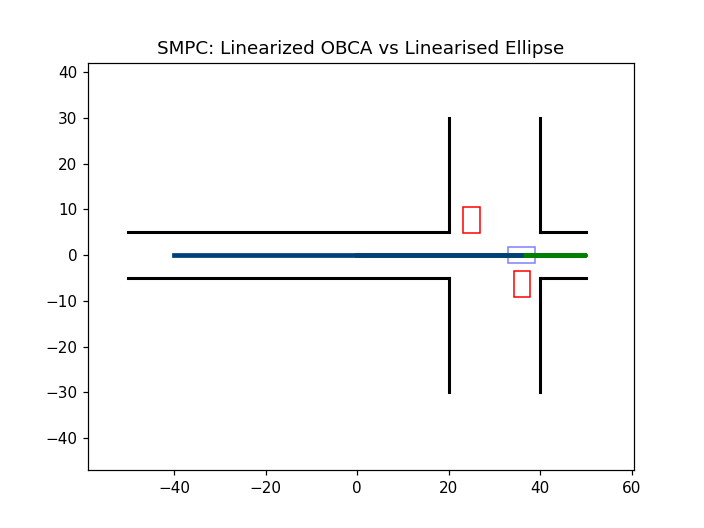

In [17]:
%matplotlib notebook
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from celluloid import Camera
from IPython.display import HTML

fig= plt.figure()
camera = Camera(fig)

for i in range(Sim_ol.t+1):
    plt.plot([-50, 20], [5, 5], color='k', lw=2)
    plt.plot([-50, 20], [-5, -5], color='k', lw=2)
    plt.plot([40, 50], [5, 5], color='k', lw=2)
    plt.plot([40, 50], [-5, -5], color='k', lw=2)
    plt.plot([20, 20], [5, 30], color='k', lw=2)
    plt.plot([40, 40], [5, 30], color='k', lw=2)
    plt.plot([20, 20], [-5, -30], color='k', lw=2)
    plt.plot([40, 40], [-5, -30], color='k', lw=2)
    plt.plot(Sim.ev_traj[0,:i], Sim.ev_traj[1,:i], color='green', lw=3, label="lin_OBCA")
    plt.plot(Sim_ol.ev_traj[0,:i], Sim_ol.ev_traj[1,:i], color='blue', lw=3, alpha=0.5, label="lin_ellipse")
#     plt.plot(Sim.tv_traj[0][0,:i], Sim.tv_traj[0][1,:i], color='orange')
#     plt.plot(Sim.tv_traj[1][0,:i], Sim.tv_traj[1][1,:i], color='orange')
    plt.gca().add_patch(Rectangle((Sim_ol.tv_traj[0][0,i-1]-1.8,Sim_ol.tv_traj[0][1,i-1]-2.9),3.6,5.8,linewidth=1,edgecolor='r',facecolor='none'))
    plt.gca().add_patch(Rectangle((Sim_ol.tv_traj[1][0,i-1]-1.8,Sim_ol.tv_traj[1][1,i-1]-2.9),3.6,5.8,linewidth=1,edgecolor='r',facecolor='none'))
    if i<=Sim.t:
        plt.gca().add_patch(Rectangle((Sim.ev_traj[0,i-1]-2.9,Sim.ev_traj[1,i-1]-1.8),5.8,3.6,linewidth=1,edgecolor='g',facecolor='none'))
    plt.gca().add_patch(Rectangle((Sim_ol.ev_traj[0,i-1]-2.9,Sim_ol.ev_traj[1,i-1]-1.8),5.8,3.6,linewidth=1,edgecolor='b',facecolor='none', alpha=0.5))
    plt.axis('equal')
    plt.title("SMPC: Linearized OBCA vs Linearised Ellipse")
#     plt.legend()
    camera.snap()
    
animation = camera.animate()
# animation.save('animation_CL.gif')
# animation.save('animation_CL.gif', writer='Pillow')

<IPython.core.display.Javascript object>


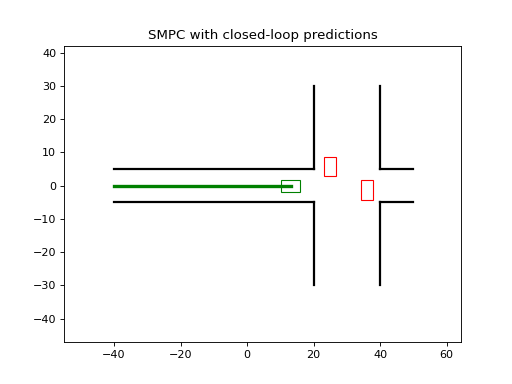

In [21]:
%matplotlib notebook
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from celluloid import Camera
from IPython.display import HTML

fig= plt.figure()
camera = Camera(fig)

for i in range(Sim.t+1):
    plt.plot([-40, 20], [5, 5], color='k', lw=2)
    plt.plot([-40, 20], [-5, -5], color='k', lw=2)
    plt.plot([40, 50], [5, 5], color='k', lw=2)
    plt.plot([40, 50], [-5, -5], color='k', lw=2)
    plt.plot([20, 20], [5, 30], color='k', lw=2)
    plt.plot([40, 40], [5, 30], color='k', lw=2)
    plt.plot([20, 20], [-5, -30], color='k', lw=2)
    plt.plot([40, 40], [-5, -30], color='k', lw=2)
    plt.plot(Sim.ev_traj[0,:i], Sim.ev_traj[1,:i], color='green', lw=3)
#     plt.plot(Sim.ev_traj[0,:i], Sim.ev_traj[1,:i], color='green', lw=3)
#     plt.plot(Sim.tv_traj[0][0,:i], Sim.tv_traj[0][1,:i], color='orange')
#     plt.plot(Sim.tv_traj[1][0,:i], Sim.tv_traj[1][1,:i], color='orange')
    plt.gca().add_patch(Rectangle((Sim.tv_traj[0][0,i-1]-1.8,Sim.tv_traj[0][1,i-1]-2.9),3.6,5.8,linewidth=1,edgecolor='r',facecolor='none'))
    plt.gca().add_patch(Rectangle((Sim.tv_traj[1][0,i-1]-1.8,Sim.tv_traj[1][1,i-1]-2.9),3.6,5.8,linewidth=1,edgecolor='r',facecolor='none'))
    plt.gca().add_patch(Rectangle((Sim.ev_traj[0,i-1]-2.9,Sim.ev_traj[1,i-1]-1.8),5.8,3.6,linewidth=1,edgecolor='g',facecolor='none'))
    plt.axis('equal')
    plt.title("SMPC with closed-loop predictions")
    camera.snap()
    
animation = camera.animate()
# animation.save('animation_CL.gif')
# animation.save('animation_CL.gif', writer='Pillow')

In [ ]:
%matplotlib notebook
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from celluloid import Camera

fig= plt.figure()
camera = Camera(fig)

for i in range(Sim_ol.t+1):
    plt.plot([-50, 20], [5, 5], color='k', lw=2)
    plt.plot([-50, 20], [-5, -5], color='k', lw=2)
    plt.plot([40, 50], [5, 5], color='k', lw=2)
    plt.plot([40, 50], [-5, -5], color='k', lw=2)
    plt.plot([20, 20], [5, 30], color='k', lw=2)
    plt.plot([40, 40], [5, 30], color='k', lw=2)
    plt.plot([20, 20], [-5, -30], color='k', lw=2)
    plt.plot([40, 40], [-5, -30], color='k', lw=2)
    plt.plot(Sim_ol.ev_traj[0,:i], Sim_ol.ev_traj[1,:i], color='green', lw=3)
#     plt.plot(Sim.tv_traj[0][0,:i], Sim.tv_traj[0][1,:i], color='orange')
#     plt.plot(Sim.tv_traj[1][0,:i], Sim.tv_traj[1][1,:i], color='orange')
    plt.gca().add_patch(Rectangle((Sim_ol.tv_traj[0][0,i-1]-1.8,Sim_ol.tv_traj[0][1,i-1]-2.9),3.6,5.8,linewidth=1,edgecolor='r',facecolor='none'))
    plt.gca().add_patch(Rectangle((Sim_ol.tv_traj[1][0,i-1]-1.8,Sim_ol.tv_traj[1][1,i-1]-2.9),3.6,5.8,linewidth=1,edgecolor='r',facecolor='none'))
    plt.gca().add_patch(Rectangle((Sim_ol.ev_traj[0,i-1]-2.9,Sim_ol.ev_traj[1,i-1]-1.8),5.8,3.6,linewidth=1,edgecolor='g',facecolor='none'))
    plt.axis('equal')
    plt.title("SMPC with open-loop predictions")
    camera.snap()
    
animation = camera.animate()  
animation.save('animation_OL.gif')
# animation.save('animation_OL.mp4')

In [ ]:
## Plotting
%matplotlib notebook

import matplotlib.pyplot as plt


fig=plt.figure(figsize=(10, 8))
# fig=plt.figure()
a1=plt.subplot(421)#(421)
plt.plot(Sim0.ev_traj[0,:Sim0.t], color='g',linestyle='-', label='ego')
plt.plot(Sim0.tv_traj[0][0,:Sim0.t], color='tab:orange',linestyle='-', label= 'target')
plt.plot(Sim0.s_f*np.ones(Sim0.t), color='r',linewidth=2.0, linestyle='-', label= 's_f')
plt.fill_between(np.arange(Sim0.t), Sim0.tv_traj[0][0,:Sim0.t],Sim0.tv_traj[0][0,:Sim0.t]+Sim0.d_nom, color='m',alpha=0.2, label= 'unsafe')
# plt.plot(Sim.ev_traj[0,:Sim.t]-Sim.tv_traj[0][0,:Sim.t], color='b',linestyle='-', label='EV-TV distance')
plt.xlabel('time')
plt.ylabel('s',fontsize=18)
plt.xlim(0,Sim0.t)
a1.set_title("TV mode=1 (EV-agnostic)")
# plt.legend()
a12=plt.subplot(422, sharey=a1)#(421)
plt.plot(Sim.ev_traj[0,:Sim.t], color='g',linestyle='-', label='ego')
plt.plot(Sim.tv_traj[0][0,:Sim.t], color='tab:orange',linestyle='-', label= 'target')
plt.plot(Sim.s_f*np.ones(Sim.t), color='r',linewidth=2.0, linestyle='-', label= 's_f')
plt.fill_between(np.arange(Sim.t), Sim.tv_traj[0][0,:Sim.t],Sim.tv_traj[0][0,:Sim.t]+Sim.d_nom, color='m',alpha=0.2, label= 'unsafe')
# plt.plot(Sim.ev_traj[0,:Sim.t]-Sim.tv_traj[0][0,:Sim.t], color='b',linestyle='-', label='EV-TV distance')
# plt.xlabel('time')
# plt.ylabel('s',fontsize=18)
plt.xlim(0,Sim.t)
plt.legend()
a12.set_title("TV mode=2 (EV-tailing)")
a2=plt.subplot(423)#(423)
plt.plot(Sim0.ev_traj[1,:Sim0.t], color='g',linestyle='-', label='ego')
plt.plot(Sim0.tv_traj[0][1,:Sim0.t], color='tab:orange',linestyle='-', label= 'target')
plt.plot(14.0*np.ones(Sim0.t), color='r',linewidth=2.0,linestyle='-', label= 'v_max')
plt.plot(0.0*np.ones(Sim0.t), color='y',linewidth=2.0,linestyle='-', label= 'v_min')
plt.xlabel('time')
plt.ylabel('v',fontsize=18)
plt.xlim(0,Sim0.t)
# plt.legend()
a22=plt.subplot(424, sharey=a2)#(423)
plt.plot(Sim.ev_traj[1,:Sim.t], color='g',linestyle='-', label='ego')
plt.plot(Sim.tv_traj[0][1,:Sim.t], color='tab:orange',linestyle='-', label= 'target')
plt.plot(14.0*np.ones(Sim.t), color='r',linewidth=2.0,linestyle='-', label= 'v_max')
plt.plot(0.0*np.ones(Sim.t), color='y',linewidth=2.0,linestyle='-', label= 'v_min')
plt.xlabel('time')
# plt.ylabel('v',fontsize=18)
plt.xlim(0,Sim.t)
plt.legend()
a3=plt.subplot(425)#(425)
t_array=np.arange(Sim0.t)
ctr1=0
ctr2=0
for t1, t2, u1,u2 in zip(t_array[:-1], t_array[1:], Sim0.ev_u[0,:Sim0.t-1], Sim0.ev_u[0,1:Sim0.t]):
    if opt_list0[t1]:
        if not ctr1:
            plt.plot([t1, t2], [u1, u2], 'k', label='u_t')
            ctr1+=1
        else:
            plt.plot([t1, t2], [u1, u2], 'k')
    else :
        if not ctr2:
            plt.plot([t1, t2], [u1, u2], 'k', label='u_t')
            ctr2+=1
        else:
            plt.plot([t1, t2], [u1, u2], 'k')
plt.plot(3.0*np.ones(Sim0.t), color='r',linewidth=2.0,linestyle='-', label= 'a_max')
plt.plot(-5.0*np.ones(Sim0.t), color='y',linewidth=2.0,linestyle='-', label= 'a_min')
# plt.plot(Sim.ev_u[0,:Sim.t], '-r', label='ego')
plt.xlabel('time')
plt.ylabel('a',fontsize=18)
plt.xlim(0,Sim0.t)
# plt.legend()
a32=plt.subplot(426, sharey=a3)#(425)
t_array=np.arange(Sim.t)
ctr1=0
ctr2=0
for t1, t2, u1,u2 in zip(t_array[:-1], t_array[1:], Sim.ev_u[0,:Sim.t-1], Sim.ev_u[0,1:Sim.t]):
    if opt_list[t1]:
        if not ctr1:
            plt.plot([t1, t2], [u1, u2], 'k', label='u_t')
            ctr1+=1
        else:
            plt.plot([t1, t2], [u1, u2], 'k')
    else :
        if not ctr2:
            plt.plot([t1, t2], [u1, u2], 'k')
            ctr2+=1
        else:
            plt.plot([t1, t2], [u1, u2], 'k')
plt.plot(3.0*np.ones(Sim.t), color='r',linewidth=2.0,linestyle='-', label= 'a_max')
plt.plot(-5.0*np.ones(Sim.t), color='y',linewidth=2.0,linestyle='-', label= 'a_min')
# plt.plot(Sim.ev_u[0,:Sim.t], '-r', label='ego')
plt.xlabel('time')
# plt.ylabel('a',fontsize=18)
plt.xlim(0,Sim.t)
plt.legend()
a4=plt.subplot(427)#(427)
plt.plot(Sim0.G0_est[0][0][0:Sim0.t], '-r', label='estimated_mode=1')
plt.plot(Sim0.G0_est[1][0][0:Sim0.t], '-b', label='estimated_mode=2')
plt.plot(Sim0.G_traj[0][0:Sim0.t], '--k', label= 'real_mode=1')
plt.xlabel('time',fontsize=18)
plt.ylabel('$\gamma$', fontsize=17)
plt.xlim(0,Sim0.t)
# plt.legend()
a42=plt.subplot(428, sharey=a4)#(427)
plt.plot(Sim.G0_est[0][0][0:Sim.t], '-r', label='estimated_mode=1')
plt.plot(Sim.G0_est[1][0][0:Sim.t], '-b', label='estimated_mode=2')
plt.plot(Sim.G_traj[0][0:Sim.t], '--k', label= 'real_weight')
plt.xlabel('time',fontsize=18)
# plt.ylabel('$\gamma$', fontsize=17)
plt.xlim(0,Sim.t)
plt.legend()
# plt.subplot(422)
# plt.plot(Sim_ia.ev_traj[0,:Sim_ia.t], '-r', label='ego')
# plt.plot(Sim_ia.tv_traj[0][0,:Sim_ia.t], '-b', label= 'target')
# plt.xlabel('time')
# plt.ylabel('s')
# plt.legend()
# plt.subplot(424)
# plt.plot(Sim_ia.ev_traj[1,:Sim_ia.t], '-r', label='ego')
# plt.plot(Sim_ia.tv_traj[0][1,:Sim_ia.t], '-b', label= 'target')
# plt.xlabel('time')
# plt.ylabel('v')
# plt.legend()
# plt.subplot(426)
# t_array=np.arange(Sim_ia.t)
# ctr1=0
# ctr2=0
# for t1, t2, u1,u2 in zip(t_array[:-1], t_array[1:], Sim_ia.ev_u[0,:Sim_ia.t-1], Sim_ia.ev_u[0,1:Sim_ia.t]):
#     if opt_list_ia[t1]:
#         if not ctr1:
#             plt.plot([t1, t2], [u1, u2], 'r', label='feasible')
#             ctr1+=1
#         else:
#             plt.plot([t1, t2], [u1, u2], 'r')
#     else :
#         if not ctr2:
#             plt.plot([t1, t2], [u1, u2], 'k', label='infeasible')
#             ctr2+=1
#         else:
#             plt.plot([t1, t2], [u1, u2], 'k')
# # plt.plot(Sim_ne.ev_u[0,:Sim_ne.t], '-r', label='ego')
# plt.xlabel('time')
# plt.ylabel('a')
# plt.legend()
# plt.subplot(428)
# plt.plot(Sim_ia.G0_est[0][0][1:Sim_ia.t], '-r', label='estimated_mode_0')
# plt.plot(Sim_ia.G0_est[1][0][1:Sim_ia.t], '-b', label='estimated_mode_1')
# plt.plot(Sim_ia.G_traj[0][1:Sim_ia.t], '--k', label= 'real_0')
# plt.xlabel('time')
# plt.ylabel('$\gamma$')
plt.legend()
plt.show()
# plt.subplot(422)
# plt.plot(Sim_ne.ev_traj[0,:Sim_ne.t], '-r', label='ego')
# plt.plot(Sim_ne.tv_traj[0][0,:Sim_ne.t], '-b', label= 'target')
# plt.xlabel('time')
# plt.ylabel('s')
# plt.legend()
# plt.subplot(424)
# plt.plot(Sim_ne.ev_traj[1,:Sim_ne.t], '-r', label='ego')
# plt.plot(Sim_ne.tv_traj[0][1,:Sim_ne.t], '-b', label= 'target')
# plt.xlabel('time')
# plt.ylabel('v')
# plt.legend()
# plt.subplot(426)
# t_array=np.arange(Sim_ne.t)
# ctr1=0
# ctr2=0
# for t1, t2, u1,u2 in zip(t_array[:-1], t_array[1:], Sim_ne.ev_u[0,:Sim_ne.t-1], Sim_ne.ev_u[0,1:Sim_ne.t]):
#     if opt_list_ne[t1]:
#         if not ctr1:
#             plt.plot([t1, t2], [u1, u2], 'r', label='feasible')
#             ctr1+=1
#         else:
#             plt.plot([t1, t2], [u1, u2], 'r')
#     else :
#         if not ctr2:
#             plt.plot([t1, t2], [u1, u2], 'k', label='infeasible')
#             ctr2+=1
#         else:
#             plt.plot([t1, t2], [u1, u2], 'k')
# # plt.plot(Sim_ne.ev_u[0,:Sim_ne.t], '-r', label='ego')
# plt.xlabel('time')
# plt.ylabel('a')
# plt.legend()
# plt.subplot(428)
# plt.plot(Sim_ne.G0_est[0][0][1:Sim_ne.t], '-r', label='estimated_mode_0')
# plt.plot(Sim_ne.G0_est[1][0][1:Sim_ne.t], '-b', label='estimated_mode_1')
# plt.plot(Sim_ne.G_traj[0][1:Sim_ne.t], '--k', label= 'real_0')
# plt.xlabel('time')
# plt.ylabel('$\gamma$')
# plt.legend()
# plt.show()
plt.savefig('new_ia_4.png')
# plt.subplot(3,2,1)
# plt.plot(Sim.ev_traj[0,:Sim.t], '-r', label='ego')
# plt.plot(Sim.tv_traj[0][0,:Sim.t], '-b', label= 'target')
# plt.xlabel('time')
# plt.ylabel('s')
# plt.figure(2)
# plt.plot(Sim_ne.ev_traj[0,:Sim_ne.t], '-r')
# plt.plot(Sim_ne.tv_traj[0][0,:Sim_ne.t], '-b')

In [ ]:
from random import sample
a=['a', 'b', 'c', 'd']
l=[0,1,2,3]
print(a[sample(l,1)[0]])

In [ ]:
a=-1*ca.DM.ones(6,2)
print(ca.sum1(a[:,0]))